# **ML for NLP: New York Times comments**

The *New York Times* is an American daily newspaper. With its 1,600 journalists, 35 foreign bureaus and 5 million subscribers, it is one of the leading newspapers in the US and worldwide. Over the last few years, the US political scene has become increasingly polarised and the *New York Times* has been at the center of it, repeatedly accused by right-wing pundits, politicians and sympathizers of embodying the East-Coast elite hostile to Donald Trump. 
The aim of this notebook is to investigate how sentiment analysis on the *New York Times* comments (https://www.kaggle.com/aashita/nyt-comments) can reflect this high level of polarisation. We analyse the sentiments expressed in the comments section for the period 2017-2018 adopting two angles: one is the traditional approach of sentiment analysis, *i.e.* classification of text data into a "positive" category and a "negative" one, the other approach is a political labelling of the comments into a "Republican" category and a "Democrat" one. We compare the two approaches and qualitatively analyze their results. Finally, we link the political-labelled comments with the articles they are responding to by superposing a clustering performed on the articles and the labelling of their comments. We conclude that our approach allows to reflect quite well the political scene's polarisation during Trump era regarding the language elements and the topics of interest of the two major parties' advocates.


In [ ]:
# Useful packages
import pandas as pd
import os 
import numpy as np
import gc
import time
import matplotlib.pyplot as plt
import random
import math
import re
import string

# Cleaning datasets
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
from gensim.parsing.porter import PorterStemmer
from tqdm import tqdm

# SST
from datasets import list_datasets, load_dataset, list_metrics, load_metric

# Embedding
from gensim.models import Word2Vec
from multiprocessing import cpu_count
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.phrases import Phrases, Phraser

# Classifiers and scores
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,roc_auc_score

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.nn.functional import one_hot

# Keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras import metrics


# Wordcloud and clustering
from wordcloud import  WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1 import AxesGrid


%load_ext autoreload
%autoreload 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#changing the working directory
%cd /content/drive/My Drive/data_NYT

/content/drive/My Drive/data_NYT


# **Sentiment analysis on the New York Times comments**

In this part we propose two diffrerent sentiment analysis approaches. First, we try to use the Stanford Sentiment Treebank so we can train algorithms and use them on our dataset in order to determine wether comments are negative or positive. Second, we try to construct our own labelling by using a part of our data. This second labelling is political, comments are either considered to be democrats or republicans.

In [ ]:
#we load the comments data
dfcomJan17=pd.read_csv("CommentsJan2017.csv")
dfcomJan17["month"]=["Jan17"]*len(dfcomJan17)
dfcomJan18=pd.read_csv("CommentsJan2018.csv")
dfcomJan18["month"]=["Jan18"]*len(dfcomJan18)
dfcomFeb17=pd.read_csv("CommentsFeb2017.csv")
dfcomFeb17["month"]=["Feb17"]*len(dfcomFeb17)
dfcomFeb18=pd.read_csv("CommentsFeb2018.csv")
dfcomFeb18["month"]=["Feb18"]*len(dfcomFeb18)
dfcomApr18=pd.read_csv("CommentsApril2018.csv")
dfcomApr18["month"]=["Apr18"]*len(dfcomApr18)
dfcomApr17=pd.read_csv("CommentsApril2017.csv")
dfcomApr17["month"]=["Apr17"]*len(dfcomApr17)
dfcomMar17=pd.read_csv("CommentsMarch2017.csv")
dfcomMar17["month"]=["Mar17"]*len(dfcomMar17)
dfcomMar18=pd.read_csv("CommentsMarch2018.csv")
dfcomMar18["month"]=["Mar18"]*len(dfcomMar18)
dfcomMay17=pd.read_csv("CommentsMay2017.csv")
dfcomMay17["month"]=["May17"]*len(dfcomMay17)

dfcom=pd.concat([dfcomJan17,dfcomJan18,dfcomFeb17,dfcomFeb18,dfcomApr18,dfcomApr17,dfcomMar17,dfcomMar18,dfcomMay17])

#selection of the comments not written in reply to other but rather being a direct reaction to the article itself
dfcomnoreply=dfcom.loc[dfcom["inReplyTo"]==0] 
#selection of the sections dealing with politics
dfcompol=dfcomnoreply.loc[dfcomnoreply["newDesk"].isin(["OpEd","National","Washington","Editorial","Politics"])]

del dfcom 
del dfcomJan17
del dfcomJan18
del dfcomFeb17
del dfcomFeb18
del dfcomApr18
del dfcomApr17
del dfcomMar17
del dfcomMar18
del dfcomMay17
del dfcomnoreply
gc.collect() #memory conservation
#repartition of the comments depending on the NYT sections
dfcompol.newDesk.value_counts()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,15,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/li

OpEd          590387
National      276024
Washington    147544
Editorial     131342
Politics        7629
Name: newDesk, dtype: int64

In [ ]:
dfcompol.head(5)

,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,typeOfMaterial,month
0,1483455908,58691a5795d0e039260788b9,1324.0,For all you Americans out there --- still rejo...,20969730.0,20969730.0,<br/>,comment,1.483426e+09,1.0,0,0.0,National,0.0,NaN,20969730,https://graphics8.nytimes.com/images/apps/time...,1.0,5.0,NaN,0.0,NaN,Politics,0,approved,1.0,0.0,1483455908,N. Smith,64679318.0,New York City,NaN,NaN,News,Jan17
1,1483455656,58691a5795d0e039260788b9,1324.0,Obamas policies may prove to be the least of t...,20969325.0,20969325.0,<br/>,comment,1.483417e+09,1.0,0,0.0,National,0.0,NaN,20969325,https://graphics8.nytimes.com/images/apps/time...,1.0,3.0,NaN,0.0,NaN,Politics,0,approved,1.0,0.0,1483455656,Kilocharlie,69254188.0,Phoenix,NaN,NaN,News,Jan17
2,1483455655,58691a5795d0e039260788b9,1324.0,Democrats are comprised of malcontents who gen...,20969855.0,20969855.0,<br/>,comment,1.483431e+09,1.0,0,0.0,National,0.0,NaN,20969855,https://graphics8.nytimes.com/images/apps/time...,1.0,3.0,NaN,0.0,NaN,Politics,0,approved,1.0,0.0,1483455655,Frank Fryer,76788711.0,Florida,NaN,NaN,News,Jan17
3,1483455653,58691a5795d0e039260788b9,1324.0,The picture in this article is the face of con...,20969407.0,20969407.0,<br/>,comment,1.483419e+09,1.0,0,0.0,National,0.0,NaN,20969407,https://graphics8.nytimes.com/images/apps/time...,1.0,3.0,NaN,0.0,NaN,Politics,0,approved,1.0,0.0,1483455653,James Young,72718862.0,Seattle,NaN,NaN,News,Jan17
4,1483455216,58691a5795d0e039260788b9,1324.0,Elections have consequences.,20969274.0,20969274.0,NaN,comment,1.483417e+09,1.0,0,0.0,National,0.0,NaN,20969274,https://graphics8.nytimes.com/images/apps/time...,1.0,3.0,NaN,0.0,NaN,Politics,0,approved,1.0,0.0,1483455216,M.,7529267.0,Seattle,NaN,NaN,News,Jan17


In [ ]:
#we discard comments that are too long
#it will allow to reduce memory consumption when we will deal with the embeddings and the prediction models
#we also hope it will help the models as vectors dimension will be reduced a lot
dfcom=dfcompol.loc[dfcompol['commentBody'].apply(lambda x: len(x)<400)]
#some comments are duplicated 
dfcom=dfcom.drop_duplicates(subset='commentID').reset_index(drop=True)
print(len(dfcom))

del dfcompol
gc.collect()

596615


0

# Pre-training the model: SST Treebank

First thing first, we need to download the database. We use the SST-2 database, with binary labels. You can find it at the url: https://huggingface.co/datasets/toriving/sst2.

In [ ]:
!pip install datasets

     |████████████████████████████████| 204kB 16.5MB/s 
     |████████████████████████████████| 112kB 45.7MB/s 
     |████████████████████████████████| 245kB 43.1MB/s 


In [ ]:
# Load a dataset and print the first example in the training set
sst_dataset = load_dataset('toriving/sst2')
sst_dataset.num_columns, sst_dataset.num_rows 
sst_dataset

Using custom data configuration default


Dataset ss_t2 downloaded and prepared to /root/.cache/huggingface/datasets/ss_t2/default/0.0.0/90167692658fa4abca2ffa3ede1a43a71e2bf671078c5c275c64c4231d5a62fa. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6920
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1821
    })
})

In [ ]:
# We associate each part to a specific database
train_dataset = pd.DataFrame(sst_dataset['train'])
val_dataset = pd.DataFrame(sst_dataset['validation'])
test_dataset = pd.DataFrame(sst_dataset['test'])

train_dataset.head()

,label,text
0,0,The Rock is destined to be the 21st Century 's...
1,0,The gorgeously elaborate continuation of `` Th...
2,0,Singer\/composer Bryan Adams contributes a sle...
3,0,Yet the act is still charming here .
4,0,Whether or not you 're enlightened by any of D...


## First step, cleaning the SST database

In [ ]:
# first we create functions to clean the symbols in the reviews
def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  tokens = filter(lambda x: "href" not in x, tokens)
  tokens = filter(lambda x: "target" not in x, tokens)
  tokens = filter(lambda x: "<" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)
def remove_contraction(sample):
    sample = sample.lower()
    sample = sample.replace('won\'t', ' will not')    
    sample = sample.replace('n\'t',' not')
    sample = sample.replace('\'ll',' will') 
    sample = sample.replace('it\'s','it is')    
    sample = sample.replace('he\'s','he is')    
    sample = sample.replace('she\'s','she is')    
    sample = sample.replace('\'re', ' are')
    sample = sample.replace('that\'s', 'that is')
    return sample

def tokenize_url_hashtags_1(corpus):
  tokenizer = TweetTokenizer() 
  tokenized_sentences = []
  for sentence in tqdm(corpus):
    sentence = remove_contraction(sentence)
    tokens = tokenizer.tokenize(sentence)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)
  return tokenized_sentences

We need to tokenize the reviews in rder to classify them. 

In [ ]:
train_dataset['tokens'] = tokenize_url_hashtags_1(train_dataset.text)
val_dataset['tokens'] = tokenize_url_hashtags_1(val_dataset.text)
test_dataset['tokens'] = tokenize_url_hashtags_1(test_dataset.text)
train_dataset.head()

100%|██████████| 1821/1821 [00:00<00:00, 12482.21it/s]


,label,text,tokens
0,0,The Rock is destined to be the 21st Century 's...,"[the, rock, is, destined, to, be, the, 21st, c..."
1,0,The gorgeously elaborate continuation of `` Th...,"[the, gorgeously, elaborate, continuation, of,..."
2,0,Singer\/composer Bryan Adams contributes a sle...,"[singer, \, /, composer, bryan, adams, contrib..."
3,0,Yet the act is still charming here .,"[yet, the, act, is, still, charming, here, .]"
4,0,Whether or not you 're enlightened by any of D...,"[whether, or, not, you, are, enlightened, by, ..."


In [ ]:
# We only keep the interesting part of the database
sst_train = pd.DataFrame({'tokens':train_dataset.tokens, 'label':train_dataset.label})
sst_val = pd.DataFrame({'tokens':val_dataset.tokens, 'label':val_dataset.label})
sst_test = pd.DataFrame({'tokens':test_dataset.tokens, 'label':test_dataset.label})

In [ ]:
len(sst_train), len(sst_val), len(sst_test)

(6920, 872, 1821)

## Word2Vec representation and fitting


We try the Word2Vec embedding method, and then we will classify with classic classifier (Decision tree and Random Forest).

In [ ]:
cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

print("Training the sst W2V ...")
start = time.time()

sst1 = Word2Vec(sst_train.tokens, size=100, window=5, min_count=3, workers=cpu, sg=1) #we use skip-gram
print('Word2Vec Train Created in {} seconds.'.format(time.time() - start))

sst1.train(sst_train.tokens, total_examples=len(sst_train), epochs=10)
sst_train_wv = sst1.wv

del sst1

start = time.time()

sst1 = Word2Vec(sst_test.tokens, size=100, window=5, min_count=3, workers=cpu, sg=1) #we use skip-gram
print('Word2Vec Test Created in {} seconds.'.format(time.time() - start))

sst1.train(sst_test.tokens, total_examples=len(sst_test), epochs=10)
sst_test_wv = sst1.wv

del sst1

The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the sst W2V ...
Word2Vec Train Created in 2.9504761695861816 seconds.
Word2Vec Test Created in 0.6920669078826904 seconds.


In [ ]:
#Creation of a Word2Vec dataframe for the fitting and modelling

def tokens2vectors(model, tokenCorpus):
    new_sample = list()
    i=0
    labels=[]
    for sample in tokenCorpus:
        Vec = list()
        for token in sample:
            try : 
                Vec.append(model.get_vector(token)  )
            except: 
                i+=+1
                Vec.append(np.zeros(100)) 
        new_sample.append(np.mean(Vec, axis=0))    
    return np.array(new_sample)

X_train= tokens2vectors(sst_train_wv, sst_train.tokens)

Y_train=[]
labels=[]
index_label=0
for x in list(X_train):
    try: 
        Y_train.append(list(x))
        labels.append(sst_train.label[index_label])
        index_label+=1
    except : 
        index_label+=1
        pass
    
sst_train_word2vec= pd.DataFrame(Y_train,columns=[str(x) for x in range(len(Y_train[0]))])

In [ ]:
# We fit a couple of classifiers : Decision Tree and Random Forest

#Initialize the model
tree_decision_wv = DecisionTreeClassifier()
rf_decision_wv = RandomForestClassifier()

start_time = time.time()
# Fit the model
tree_decision_wv.fit(sst_train_word2vec, labels)
rf_decision_wv.fit(sst_train_word2vec, labels)

print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))


Time taken to fit the model with word2vec vectors: 7.421555042266846


In [ ]:
# Creation of a Word2Vec dataframe for the testing
X_test= tokens2vectors(sst_test_wv, sst_test.tokens)

Y_test=[]
labels_test=[]
index_label=0
for x in list(X_test):
    try: 
        Y_test.append(list(x))
        labels_test.append(sst_test.label[index_label])
        index_label+=1
    except : 
        index_label+=1
        pass
    
sst_test_word2vec= pd.DataFrame(Y_test,columns=[str(x) for x in range(len(Y_test[0]))])

### Our results:

In [ ]:
tree_predictions_word2vec = tree_decision_wv.predict(sst_test_word2vec)
rf_predictions_word2vec = rf_decision_wv.predict(sst_test_word2vec)

In [ ]:
prf_score_tree = list(precision_recall_fscore_support(labels_test, tree_predictions_word2vec, average = 'binary'))
prf_score_tree.append(accuracy_score(labels_test, tree_predictions_word2vec))
prf_score_rf = list(precision_recall_fscore_support(labels_test, rf_predictions_word2vec, average = 'binary'))
prf_score_rf.append(accuracy_score(labels_test, rf_predictions_word2vec))

results = pd.DataFrame(index = ['Decision Tree', 'Random Forest'], 
          columns = ['Precision', 'Recall', 'F1 score', 'support', 'Accuracy']
          )
results.loc['Decision Tree'] = prf_score_tree
results.loc['Random Forest'] = prf_score_rf

In [ ]:
results

,Precision,Recall,F1 score,support,Accuracy
Decision Tree,0.488423,0.485746,0.487081,None,0.487644
Random Forest,0.498775,0.892544,0.639937,None,0.49698


We have rather good F1-scores for a Word2Vec embedding, with almost 60%with the Random Forest.

In [ ]:
print(results.to_latex(index = False))

\begin{tabular}{lllll}
\toprule
Precision &    Recall &  F1 score & support &  Accuracy \\
\midrule
 0.488423 &  0.485746 &  0.487081 &    None &  0.487644 \\
 0.498775 &  0.892544 &  0.639937 &    None &   0.49698 \\
\bottomrule
\end{tabular}



## TF-IDF representation and fitting

In [ ]:
# Creation of the database for the TF-IDF embedding
corpus=sst_train.tokens
corpus_train=[]
for sent in corpus: 
    sentence=''
    for word in sent:
        sentence = sentence+' '+word
    corpus_train.append(sentence)

corpus=sst_test.tokens
corpus_test=[]
for sent in corpus: 
    sentence=''
    for word in sent:
        sentence = sentence+' '+word
    corpus_test.append(sentence)

In [ ]:
# Creation of embedded vectors
tfidf = TfidfVectorizer(max_features = 100) 
tfidf.fit(corpus_train)
sst_train_tfidf = tfidf.transform(corpus_train)

tfidf = TfidfVectorizer(max_features = 100) 
tfidf.fit(corpus_test)
sst_test_tfidf = tfidf.transform(corpus_test)

In [ ]:
sst_train_tfidf.shape

(6920, 100)

In [ ]:
# We get the labels
labels=[]
for i in range(len(sst_train)):
      labels.append(sst_train.label[i])
      
labels_test=[]
for i in range(len(sst_test)):
        labels_test.append(sst_test.label[i])
    

In [ ]:
# We use the same classifiers (Decision Tree and Random Forest)

#Initialize the model
tree_decision_tfidf = DecisionTreeClassifier()
rf_decision_tfidf = RandomForestClassifier()

start_time = time.time()

tree_decision_tfidf.fit(sst_train_tfidf, labels)
rf_decision_tfidf.fit(sst_train_tfidf, labels)
print("Time taken to fit the model with TF-IDF: " + str(time.time() - start_time))

Time taken to fit the model with TF-IDF: 5.33933162689209


### Our results :

In [ ]:
tree_predictions_tfidf = tree_decision_tfidf.predict(sst_test_tfidf)
rf_predictions_tfidf = rf_decision_tfidf.predict(sst_test_tfidf)

In [ ]:
prf_score_tree = list(precision_recall_fscore_support(labels_test, tree_predictions_tfidf, average = 'binary'))
prf_score_tree.append(accuracy_score(labels_test, tree_predictions_tfidf))
prf_score_rf = list(precision_recall_fscore_support(labels_test, rf_predictions_tfidf, average = 'binary'))
prf_score_rf.append(accuracy_score(labels_test, rf_predictions_tfidf))

results = pd.DataFrame(index = ['Decision Tree', 'Random Forest'], 
          columns = ['Precision', 'Recall', 'F1 score', 'support', 'Accuracy']
          )
results.loc['Decision Tree'] = prf_score_tree
results.loc['Random Forest'] = prf_score_rf

In [ ]:
results

,Precision,Recall,F1 score,support,Accuracy
Decision Tree,0.536611,0.5625,0.549251,None,0.537617
Random Forest,0.569149,0.586623,0.577754,None,0.570566


Once again, those are not bad scores, but the Random Forest classifier gives a slightly lower F1-score.

In [ ]:
print(results.to_latex(index = False))

\begin{tabular}{lllll}
\toprule
Precision &    Recall &  F1 score & support &  Accuracy \\
\midrule
 0.536611 &    0.5625 &  0.549251 &    None &  0.537617 \\
 0.569149 &  0.586623 &  0.577754 &    None &  0.570566 \\
\bottomrule
\end{tabular}



## Sequence labelling with LSTM, training on SST

We create a neural network model that uses the LSTM to label our reviews. The embedding we use to create our input vectors is the default nn.Embedding.

In [ ]:
class SequenceLabeller(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes, sequence_model="LSTM"):
        super(SequenceLabeller, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        if sequence_model == "LSTM":
            # The LSTM takes word embeddings as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.seq = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        else:
            raise(Exception("Sequence model {} not supported".format(sequence_model)))

        # The linear layer that maps from hidden state space to class space
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        seq_output, (h_n,c_n) = self.seq(embeds)
        tag_space = self.hidden2tag(seq_output)
        tag_scores = F.softmax(tag_space, dim=2) # Computationally efficient for the criterion
        return tag_scores

In [ ]:
# Let's prepare the data

training_data = list(zip(sst_train.tokens, labels))
test_data = list(zip(sst_test.tokens, labels_test))

In [ ]:
training_data[:2]

[(['the',
   'rock',
   'is',
   'destined',
   'to',
   'be',
   'the',
   '21st',
   'century',
   "'",
   's',
   'new',
   '`',
   '`',
   'conan',
   "'",
   "'",
   'and',
   'that',
   'he',
   "'",
   's',
   'going',
   'to',
   'make',
   'a',
   'splash',
   'even',
   'greater',
   'than',
   'arnold',
   'schwarzenegger',
   ',',
   'jean-claud',
   'van',
   'damme',
   'or',
   'steven',
   'segal',
   '.'],
  0),
 (['the',
   'gorgeously',
   'elaborate',
   'continuation',
   'of',
   '`',
   '`',
   'the',
   'lord',
   'of',
   'the',
   'rings',
   "'",
   "'",
   'trilogy',
   'is',
   'so',
   'huge',
   'that',
   'a',
   'column',
   'of',
   'words',
   'can',
   'not',
   'adequately',
   'describe',
   'co-writer',
   '\\',
   '/',
   'director',
   'peter',
   'jackson',
   "'",
   's',
   'expanded',
   'vision',
   'of',
   'j',
   '.',
   'r',
   '.',
   'r',
   '.',
   'tolkien',
   "'",
   's',
   'middle-earth',
   '.'],
  0)]

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else len(to_ix) for w in seq]
    idxs = torch.tensor(idxs, dtype=torch.long).unsqueeze(0)
    return idxs

word_to_ix = {}
tag_to_ix = {}
for sent, tag in training_data:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(tag_to_ix)

{0: 0, 1: 1}


Next we have to train our model. To account for the time-cost of the training, we will chose to loop through the data for `n_epochs=10`.

To reshape our input tensor into the same size than our one_hot encoded target during the training, we will take the mean of the scores on the sentence. 

In [ ]:
# A forword pass on the first sentence to instanciate the model and observe the scores before training
model = SequenceLabeller(50, 100, len(word_to_ix)+1, len(tag_to_ix)) 
inputs = prepare_sequence(training_data[0][0], word_to_ix)
with torch.no_grad():
    sent_scores = model(torch.cat([inputs])).mean(1)
    print("Input tokens {} scores {} ".format(inputs, sent_scores))

Input tokens tensor([[ 0,  1,  2,  3,  4,  5,  0,  6,  7,  8,  9, 10, 11, 11, 12,  8,  8, 13,
         14, 15,  8,  9, 16,  4, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
         29, 30, 31, 32]]) scores tensor([[0.5057, 0.4943]]) 


In [ ]:
# To see the skeleton of the model
model

SequenceLabeller(
  (word_embeddings): Embedding(14709, 50)
  (seq): LSTM(50, 100, batch_first=True)
  (hidden2tag): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
# We choose our loss function. Since it is a binary labelling, we use the nn.BCELoss
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

In [ ]:
# Training loops
n_epochs = 10
for epoch in range(n_epochs):  
    loss_mean_ep = 0
    n_sample = 0
    for sentence, tags in training_data:
        if len(sentence) < 2: continue
        # Step 1. We clear the gradients out before each instance
        model.zero_grad()
        # Step 2. Get our inputs into tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence([tags], tag_to_ix)
        one_hot_targets = one_hot(targets.squeeze(0), num_classes=len(tag_to_ix)).type(torch.FloatTensor)
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in).mean(1)
        # Step 4. Compute the loss, gradients, and update the parameters by calling optimizer.step()
        #print(tag_scores.shape, one_hot_targets.shape)
        loss = loss_function(tag_scores, one_hot_targets)
        loss_mean_ep += loss
        n_sample += 1
        loss.backward()
        optimizer.step()
    print("Epoch {} loss {:0.6f} ".format(epoch, loss/n_sample))

Epoch 0 loss 0.000044 
Epoch 1 loss 0.000040 
Epoch 2 loss 0.000035 
Epoch 3 loss 0.000031 
Epoch 4 loss 0.000028 
Epoch 5 loss 0.000027 
Epoch 6 loss 0.000026 
Epoch 7 loss 0.000026 
Epoch 8 loss 0.000025 
Epoch 9 loss 0.000025 


### Our results:

Now, we want to evaluate our model. We will start by qualitative evaluation (observing the scores on a couple of reviews to decide whether it has been correctly labelled) and then we will evaluate it quantatively with the classic scores (Precision, Recall, F1-score and Accuracy).

In [ ]:
# Let's observe a few random scores
test_rand = [random.randrange(len(test_data)) for i in range(100)]
test = [test_data[i] for i in test_rand]

with torch.no_grad():
  label_count = [0, 0]
  n_samples = 5
  for sentence, tag in test:
          label_count[tag] += 1
          if label_count[tag] <= n_samples:
            sentence_in = prepare_sequence(sentence, word_to_ix)
            sentence_tag = 'Positive' if tag==0 else 'Negative'
            tag_scores = model(sentence_in)
            positive_score = torch.mean(tag_scores.squeeze(0)[:, 1]).item()
            print("{} sentence scored {} \"{}\""
            "".format(sentence_tag, positive_score,' '.join(sentence)) )
          if (label_count[0] >= n_samples) and (label_count[1] >= n_samples):
            break

Negative sentence scored 0.883691668510437 "i weep for the future when a good portion of the respected critical community in this country consider blue crush to be an intelligent film about young women ."
Positive sentence scored 0.842433512210846 "thrilling , provocative and darkly funny , this timely sci-fi mystery works on so many different levels that it not only invites , it demands repeated viewings ."
Negative sentence scored 0.8462986946105957 "the streets , shot by cinematographer michael ballhaus , may be as authentic as they are mean , but it is nearly impossible to care about what happens on them ."
Negative sentence scored 0.8962221741676331 "feels like six different movies fighting each other for attention ."
Negative sentence scored 0.7441007494926453 "you will be more entertained getting hit by a bus ."
Positive sentence scored 0.9180116057395935 "we get some truly unique character studies and a cross-section of americana that hollywood could not possibly fictionalize a

In [ ]:
# Quantitative evaluation
ground_truth, scores = [], []
with torch.no_grad():
  for sentence, tag in test_data:
    sentence_in = prepare_sequence(sentence, word_to_ix)
    ground_truth.append(tag)
    tag_scores = model(sentence_in)
    scores.append(torch.mean(tag_scores.squeeze(0)[:, 1]).item())

print("The AUC is ", roc_auc_score(ground_truth, scores))
print("Precision", precision_recall_fscore_support(ground_truth, np.array(scores)>0.5,average = 'binary')[0])
print("Recall", precision_recall_fscore_support(ground_truth, np.array(scores)>0.5,average = 'binary')[1])
print("F1 score", precision_recall_fscore_support(ground_truth, np.array(scores)>0.5,average = 'binary')[2])
print("Accuracy", accuracy_score(ground_truth, np.array(scores)>0.5))

The AUC is  0.5721911006890162
Precision 0.5013743815283123
Recall 1.0
F1 score 0.6678872207982424
Accuracy 0.5019220208676551


We have an almost 70% F1-score, which is a good score.

# Political Labelling

The idea of this section is to label a portion of the dataset ourselves by detecting users having very polarised and easily identifiable opinions. We use their comments to build a labelled dataset of around 15,000 observations. Commentaries can be either Republican or Democrat. Then we use this labelled dataset to train models that we will use in order to perform sentiment analysis on the rest of our data which remains unlabelled.

### **Construction of the labelled dataset**

In [ ]:
#we try to detect polarised users so we can labelise their comments and build a labelised dataset
#we search these users using keywords that we believe are clearly associated to one of the two parties
#for example, "impeached" is associated with democrats demanding the impeachment of Donald Trump
#we look at the users who use the most this term
test_keyword=dfcom.loc[dfcom["commentBody"].apply(lambda x:'impeached' in x)]
test_keyword.userID.value_counts()

61608964.0    12
76107609.0     9
64375336.0     7
62646401.0     6
15258149.0     6
              ..
73736886.0     1
57316175.0     1
18053093.0     1
16080266.0     1
59245035.0     1
Name: userID, Length: 1619, dtype: int64

In [ ]:
#once we have an user, we have to check that his/her total number of comments is sufficient for two reasons:
#first, because we want to label the maximum comments possible at once
#most importantly because we don't want to do a labellisation that is overly focused on the keywords it would entail overfitting
#we want to spot staunch democrat/republican supporters so the algorithm can learn how they talk and about what they talk
#if the user is a staunch democrat that talks always about impeachment it is not very interesting for the algorithm
#if he talks about many topics it is much more insightful
test_user=dfcom.loc[dfcom["userID"]==61608964.0].reset_index(drop=True)

In [ ]:
#in this case the number of comments is very large
len(test_user)

556

In [ ]:
#last step, we check a few comments so we make sure the user is indeed a strong supporter of one of the two parties
#(democratic party in this case)
test_user["commentBody"][0]

'Mr. Trump has an unreal grasp on reality in general but a good grasp of fascism, a politic proven  as nuts in the past as it is today. He lives a megalomaniac dream founded on falsehood'

In [ ]:
test_user["commentBody"][59]

'Stephen Miller is a big problem to the administration. He is a very troubled person and should be fired. His parents have my pity.'

In [ ]:
test_user["commentBody"][79]

"Couldn't help but notice that Paul Ryan hung his head and could not look at the camera when he tried hard to avoid responding about Trump's s...hole remark. Is there hope for his redemption? Doubt  it. He is anti-black and a shame to Wisconsin."

In [ ]:
test_user["commentBody"][23]

'Devin Nunez is a regular mafioso. Trump’s government is full of criminals. Loyalty is not a factor. Money is!'

In [ ]:
#once we have spotted enough users whose comments were so polarised they were easy to label, we can build the dataset
listID=[]
dem1=dfcom.loc[dfcom['userID']==78358680.0]
dem1=dem1.reset_index(drop=True)
listID+=[78358680.0]


dem2=dfcom.loc[dfcom['userID']==64679318.0]
dem2=dem2.reset_index(drop=True)
listID+=[64679318.0]

#890 lignes

rep1=dfcom.loc[dfcom['userID']==11228992.0]
rep1=rep1.reset_index(drop=True)
listID+=[11228992.0]
#80 lignes

dem3=dfcom.loc[dfcom['userID']==40249616.0]
dem3=dem3.reset_index(drop=True)
listID+=[40249616.0]
#711 lignes

dem4=dfcom.loc[dfcom['userID']==65326277.0]
dem4=dem4.reset_index(drop=True)
listID+=[65326277.0]
#1150 lignes

rep2=dfcom.loc[dfcom['userID']==72585149.0]
rep2=rep2.reset_index(drop=True)
listID+=[72585149.0]
#329 lignes

rep3=dfcom.loc[dfcom['userID']==3985142.0]
rep3=rep3.reset_index(drop=True)
listID+=[3985142.0]
#258 lignes 

rep4=dfcom.loc[dfcom['userID']==65061126.0]
rep4=rep4.reset_index(drop=True)
listID+=[65061126.0]
#94 lignes

rep5=dfcom.loc[dfcom['userID']==66732933.0]
rep5=rep5.reset_index(drop=True)
listID+=[66732933.0]
#582 lignes

rep6=dfcom.loc[dfcom['userID']==9640850.0]
rep6=rep6.reset_index(drop=True)
listID+=[9640850.0]
#543 lignes

rep7=dfcom.loc[dfcom['userID']==55591219.0]
rep7=rep7.reset_index(drop=True)
listID+=[55591219.0]
#20 lignes

dem5=dfcom.loc[dfcom['userID']==47112177.0]
dem5=dem5.reset_index(drop=True)
listID+=[47112177.0]
#1269 lignes

dem6=dfcom.loc[dfcom['userID']==64396271.0]
dem6=dem6.reset_index(drop=True)
listID+=[64396271.0]
#166 lignes

rep8=dfcom.loc[dfcom['userID']==6393110.0]
rep8=rep8.reset_index(drop=True)
listID+=[6393110.0]
#99 lignes

rep9=dfcom.loc[dfcom['userID']==74604008.0]
rep9=rep9.reset_index(drop=True)
listID+=[74604008.0]
#454 lignes

rep10=dfcom.loc[dfcom['userID']==31633759.0]
rep10=rep10.reset_index(drop=True)
listID+=[31633759.0]
#213 lignes

rep11=dfcom.loc[dfcom['userID']==17222320.0]
rep11=rep11.reset_index(drop=True)
listID+=[17222320.0]
#184 lignes

rep12=dfcom.loc[dfcom['userID']==59338759.0]
rep12=rep12.reset_index(drop=True)
listID+=[59338759.0]
#143 lignes

rep13=dfcom.loc[dfcom['userID']==68586711.0]
rep13=rep13.reset_index(drop=True)
listID+=[68586711.0]
#293 lignes

rep14=dfcom.loc[dfcom['userID']==70200704.0]
rep14=rep14.reset_index(drop=True)
listID+=[70200704.0]
#96 lignes

dem7=dfcom.loc[dfcom['userID']==52099086.0]
dem7=dem7.reset_index(drop=True)
listID+=[52099086.0]
#773 lignes

rep15=dfcom.loc[dfcom['userID']==39057910.0]
rep15=rep15.reset_index(drop=True)
listID+=[39057910.0]
#128 lignes

rep16=dfcom.loc[dfcom['userID']==77697217.0]
rep16=rep16.reset_index(drop=True)
listID+=[77697217.0]
#401 lignes

dem8=dfcom.loc[dfcom['userID']==28815347.0]
dem8=dem8.reset_index(drop=True)
listID+=[28815347.0]
#45 lignes

dem9=dfcom.loc[dfcom['userID']==23325595.0]
dem9=dem9.reset_index(drop=True)
listID+=[23325595.0]
#863 lignes

dem10=dfcom.loc[dfcom['userID']==13155618.0]
dem10=dem10.reset_index(drop=True)
listID+=[13155618.0]
#30 lignes
 
dem12=dfcom.loc[dfcom['userID']==34373870.0]
dem12=dem12.reset_index(drop=True)
listID+=[34373870.0]
#474 lignes

dem13=dfcom.loc[dfcom['userID']==17050169.0]
dem13=dem13.reset_index(drop=True)
listID+=[17050169.0]
#244 lignes

rep17=dfcom.loc[dfcom['userID']==57595872.0]
rep17=rep17.reset_index(drop=True)
listID+=[57595872.0]
#137 lignes

rep18=dfcom.loc[dfcom['userID']==53531917.0]
rep18=rep18.reset_index(drop=True)
listID+=[53531917.0]
#93 lignes

rep19=dfcom.loc[dfcom['userID']==13788304.0]
rep19=rep19.reset_index(drop=True)
listID+=[13788304.0]
#168 lignes

rep20=dfcom.loc[dfcom['userID']==13838808.0]
rep20=rep20.reset_index(drop=True)
listID+=[13838808.0]
#168 lignes

rep21=dfcom.loc[dfcom['userID']==58419267.0]
rep21=rep21.reset_index(drop=True)
listID+=[58419267.0]
#58 lignes

dem14=dfcom.loc[dfcom['userID']==74515190.0]
dem14=dem14.reset_index(drop=True)
listID+=[74515190.0]
#219 lignes

dem15=dfcom.loc[dfcom['userID']==50367863.0]
dem15=dem15.reset_index(drop=True)
listID+=[50367863.0]
#146 lignes

rep22=dfcom.loc[dfcom['userID']==49838162.0]
rep22=rep22.reset_index(drop=True)
listID+=[49838162.0]
#149 lignes

rep23=dfcom.loc[dfcom['userID']==20268203.0]
rep23=rep23.reset_index(drop=True)
listID+=[20268203.0]
#57 lignes

rep24=dfcom.loc[dfcom['userID']==73928952.0]
rep24=rep24.reset_index(drop=True)
listID+=[73928952.0]
#183 lignes

rep25=dfcom.loc[dfcom['userID']==61745309.0]
rep25=rep25.reset_index(drop=True)
listID+=[61745309.0]
#48 lignes

rep26=dfcom.loc[dfcom['userID']==2354776.0]
rep26=rep26.reset_index(drop=True)
listID+=[2354776.0]

rep27=dfcom.loc[dfcom['userID']==829618.0]
rep27=rep27.reset_index(drop=True)
listID+=[829618.0]
#77 lignes

rep28=dfcom.loc[dfcom['userID']==7529267.0]
rep28=rep28.reset_index(drop=True)
listID+=[7529267.0]
#77 lignes

rep29=dfcom.loc[dfcom['userID']==46923717.0]
rep29=rep29.reset_index(drop=True)
listID+=[46923717.0]
#77 lignes

rep30=dfcom.loc[dfcom['userID']==25149390.0]
rep30=rep30.reset_index(drop=True)
listID+=[25149390.0]
#77 lignes

rep31=dfcom.loc[dfcom['userID']==1727942.0]
rep31=rep31.reset_index(drop=True)
listID+=[1727942.0]


dem16=dfcom.loc[dfcom['userID']==61029218.0]
dem16=dem16.reset_index(drop=True)
listID+=[61029218.0]

dem17=dfcom.loc[dfcom['userID']==23703782.0]
dem17=dem17.reset_index(drop=True)
listID+=[23703782.0]

dem18=dfcom.loc[dfcom['userID']==40109440.0]
dem18=dem18.reset_index(drop=True)
listID+=[40109440.0]

dem19=dfcom.loc[dfcom['userID']==25295713.0]
dem19=dem19.reset_index(drop=True)
listID+=[25295713.0]

dem20=dfcom.loc[dfcom['userID']==18044007.0]
dem20=dem20.reset_index(drop=True)
listID+=[18044007.0]

dem21=dfcom.loc[dfcom['userID']==33237662.0]
dem21=dem21.reset_index(drop=True)
listID+=[33237662.0]

dem22=dfcom.loc[dfcom['userID']==35591703.0]
dem22=dem22.reset_index(drop=True)
listID+=[35591703.0]

dem23=dfcom.loc[dfcom['userID']==61986282.0]
dem23=dem23.reset_index(drop=True)
listID+=[61986282.0]

dem24=dfcom.loc[dfcom['userID']==55750030.0]
dem24=dem24.reset_index(drop=True)
listID+=[55750030.0]

dem25=dfcom.loc[dfcom['userID']==40093565.0]
dem25=dem25.reset_index(drop=True)
listID+=[40093565.0]

dem26=dfcom.loc[dfcom['userID']==55569476.0]
dem26=dem26.reset_index(drop=True)
listID+=[55569476.0]

dem27=dfcom.loc[dfcom['userID']==26825267.0]
dem27=dem27.reset_index(drop=True)
listID+=[26825267.0]

dem28=dfcom.loc[dfcom['userID']==59413601.0]
dem28=dem28.reset_index(drop=True)
listID+=[59413601.0]

dem29=dfcom.loc[dfcom['userID']==45202528.0]
dem29=dem29.reset_index(drop=True)
listID+=[45202528.0]

dem30=dfcom.loc[dfcom['userID']==22528152.0]
dem30=dem30.reset_index(drop=True)
listID+=[22528152.0]

dem31=dfcom.loc[dfcom['userID']==37632913.0]
dem31=dem31.reset_index(drop=True)
listID+=[37632913.0]

dem32=dfcom.loc[dfcom['userID']==48241582.0]
dem32=dem32.reset_index(drop=True)
listID+=[48241582.0]

dem33=dfcom.loc[dfcom['userID']==3123529.0]
dem33=dem33.reset_index(drop=True)
listID+=[3123529.0]

dem34=dfcom.loc[dfcom['userID']==17571649.0]
dem34=dem34.reset_index(drop=True)
listID+=[17571649.0]

dem35=dfcom.loc[dfcom['userID']==61608964.0]
dem35=dem35.reset_index(drop=True)
listID+=[61608964.0]

rep32=dfcom.loc[dfcom['userID']==41572890.0]
rep32=rep32.reset_index(drop=True)
listID+=[41572890.0]

rep33=dfcom.loc[dfcom['userID']==5840605.0]
rep33=rep33.reset_index(drop=True)
listID+=[5840605.0]

rep34=dfcom.loc[dfcom['userID']==45428638.0]
rep34=rep34.reset_index(drop=True)
listID+=[45428638.0]

dem36=dfcom.loc[dfcom['userID']==77702297.0]
dem36=dem36.reset_index(drop=True)
listID+=[77702297.0]

dem37=dfcom.loc[dfcom['userID']==25715270.0]
dem37=dem37.reset_index(drop=True)
listID+=[25715270.0]

rep35=dfcom.loc[dfcom['userID']==32683058.0]
rep35=rep35.reset_index(drop=True)
listID+=[32683058.0]

rep36=dfcom.loc[dfcom['userID']==66009579.0]
rep36=rep36.reset_index(drop=True)
listID+=[66009579.0]

rep37=dfcom.loc[dfcom['userID']==75803073.0]
rep37=rep37.reset_index(drop=True)
listID+=[75803073.0]

rep38=dfcom.loc[dfcom['userID']==32683058.0]
rep38=rep38.reset_index(drop=True)
listID+=[32683058.0]

dem38=dfcom.loc[dfcom['userID']==15422447.0]
dem38=dem38.reset_index(drop=True)
listID+=[15422447.0]

dem39=dfcom.loc[dfcom['userID']==67048010.0]
dem39=dem39.reset_index(drop=True)
listID+=[67048010.0]

dem40=dfcom.loc[dfcom['userID']==64375336.0]
dem40=dem40.reset_index(drop=True)
listID+=[64375336.0]

dem41=dfcom.loc[dfcom['userID']==76107609.0]
dem41=dem41.reset_index(drop=True)
listID+=[76107609.0]

dem42=dfcom.loc[dfcom['userID']==53265405.0]
dem42=dem42.reset_index(drop=True)
listID+=[53265405.0]

rep39=dfcom.loc[dfcom['userID']==37377526.0]
rep39=rep39.reset_index(drop=True)
listID+=[37377526.0]

rep40=dfcom.loc[dfcom['userID']==65866090.0]
rep40=rep40.reset_index(drop=True)
listID+=[65866090.0]

rep41=dfcom.loc[dfcom['userID']==69015025.0]
rep41=rep41.reset_index(drop=True)
listID+=[69015025.0]

rep42=dfcom.loc[dfcom['userID']==6352804.0]
rep42=rep42.reset_index(drop=True)
listID+=[6352804.0]

rep43=dfcom.loc[dfcom['userID']==60790181.0]
rep43=rep43.reset_index(drop=True)
listID+=[60790181.0]

dem43=dfcom.loc[dfcom['userID']==17374907.0]
dem43=dem43.reset_index(drop=True)
listID+=[17374907.0]

dem44=dfcom.loc[dfcom['userID']==55689101.0]
dem44=dem44.reset_index(drop=True)
listID+=[55689101.0]

dem45=dfcom.loc[dfcom['userID']==53265405.0]
dem45=dem45.reset_index(drop=True)
listID+=[53265405.0]

dem46=dfcom.loc[dfcom['userID']==33086341.0]
dem46=dem46.reset_index(drop=True)
listID+=[33086341.0]

dem47=dfcom.loc[dfcom['userID']==58314766.0]
dem47=dem47.reset_index(drop=True)
listID+=[58314766.0]

dem48=dfcom.loc[dfcom['userID']==61641582.0]
dem48=dem48.reset_index(drop=True)
listID+=[61641582.0]

#republicans
rep=pd.concat([rep1,rep2,rep3,rep4,rep5,rep6,rep7,rep8,rep9,rep10,rep11,rep12,rep13,rep14,rep15,rep16,
               rep17,rep18,rep19,rep20,rep21,rep22,rep23,rep24,rep25,rep26,rep27,rep28,rep29,rep30,rep31,
               rep33,rep34,rep35,rep36,rep37,rep38,rep39,rep40,rep41,rep42,rep43])
#democrats
dem=pd.concat([dem1,dem2,dem3,dem4,dem5,dem6,dem7,dem8,dem9,dem10,dem12,dem13,dem14,dem15,dem16,dem17,
               dem18,dem19,dem20,dem21,dem22,dem23,dem24,dem25,dem26,dem27,dem28,dem29,dem30,dem31,dem32,
               dem33,dem34,dem35,dem36,dem37,dem38,dem39,dem40,dem41,dem42,dem43,dem44,dem45,dem46,dem47,
               dem48])

#label 1 is for democrats, label 0 for republicans
dem['label']=[1]*len(dem)
rep['label']=[0]*len(rep)

#seed
np.random.seed(1234)

#this is the labelised data we keep for building the model
dfcomlabel=pd.concat([rep,dem])
dfcomlabel=dfcomlabel.sample(frac=1) 
msk = np.random.rand(len(dfcomlabel)) < 0.8
dfcomlabel.train=dfcomlabel[msk]
dfcomlabel.train['data']=['train']*len(dfcomlabel.train)
dfcomlabel.dfcom=dfcomlabel[~msk]
dfcomlabel.dfcom['data']=['test']*len(dfcomlabel.dfcom)

#this is the non-labelised data we keep for the analysis 
dfcomnolabel=dfcom.loc[~dfcom["userID"].isin(listID)]
dfcomnolabel['label']=[99]*len(dfcomnolabel)
dfcomnolabel['data']=['analysis']*len(dfcomnolabel)

dfpol=pd.concat([dfcomnolabel,dfcomlabel.train,dfcomlabel.dfcom])

#10% of the non-labelised data is kept apart, we will later use it to apply our model 
msk = np.random.rand(len(dfpol.loc[dfpol["data"].isin(["analysis"])])) < 0.1
dfpolanalys=dfpol.loc[dfpol["data"].isin(["analysis"])].reset_index(drop=True)[msk]
dfpolanalys=dfpolanalys.reset_index(drop=True)

dfpol.label.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:429: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:431: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

99    580928
1      10206
0       5479
Name: label, dtype: int64

In [ ]:
del dfcomnolabel
del dfcomlabel.train
del dfcomlabel.dfcom
del dfcom
del dem
del msk
del rep 
gc.collect()


88

### **Data preprocessing**

Now working on our new labelled dataset we perform the traditional steps of NLP, starting with the cleaning of the data.

In [ ]:
#some comments contain html code
#some contain url links 
#some users also tag other users with the "@" character
#we also delete one-letter tokens
#(on the model of the TP2 function with few modifications) 
def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  tokens = filter(lambda x: "href" not in x, tokens)
  tokens = filter(lambda x: "target" not in x, tokens)
  tokens = filter(lambda x: "<" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

def remove_at(tokens):
  tokens = filter(lambda x: "@" not in x, tokens)
  return list(tokens)

def remove_short(tokens):
  tokens = filter(lambda x: len(x)>1,tokens)
  return list(tokens)

In [ ]:
#cleaning function (on the model of the TP2 function with few modifications) 

porter_stemmer = PorterStemmer()
def tokenize_url_hashtags(corpus,countmode=False):
  tokenizer = TweetTokenizer()
  tokenized_comments = []
  corpus=corpus.str.replace("'","") #apostrophes removal
  corpus=corpus.str.replace('“', '"') #quotations normalization 
  corpus=corpus.str.replace('”', '"') #quotations normalization 
  corpus=corpus.str.replace('".*?"', '') #quotations removal 
  corpus=corpus.array
  for sample in tqdm(corpus):
    tokens = tokenizer.tokenize(sample)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_at(tokens)
    tokens = remove_short(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokens= [porter_stemmer.stem(word) for word in tokens] #stemming
    if not countmode:
      tokenized_comments.append(tokens)
    else:
      tokenized_comments+=tokens
  return tokenized_comments

We also remove some words depending on their frequency. We remove the most frequent words as well as the words appearing only once. We believe the former do not carry much meaning while the latter are too specific to be useful.

In [ ]:
dfpolmodel=dfpol.loc[dfpol["data"].isin(["train","test"])] 
#we select the labelised dataset thanks to which the model is going to be built
dfpolmodel=dfpolmodel.reset_index(drop=True)

#this first cleaning is aimed at outputing a list of tokens so that we can build our list of stopwords
cleaned_to_count = tokenize_url_hashtags(dfpolmodel.commentBody,countmode=True)
cleaned=tokenize_url_hashtags(dfpolmodel.commentBody,countmode=False)

from collections import Counter
counts = Counter(cleaned_to_count)
print(counts)

#as stopwords we select the words that appear only once in the entire dataset as well as the words that appear the most but 
#do not carry any information such as "the"
#both negations and "trump" appear also a lot but we choose to keep them
stopwords1 = [token for token in np.unique(cleaned_to_count) if counts[token]==1]
stopwords2 = [token for token in np.unique(cleaned_to_count) if counts[token]>2000]
stopwords2.remove('trump')
stopwords2.remove('not')
stopwords=stopwords1+stopwords2

100%|██████████| 15685/15685 [00:05<00:00, 2741.06it/s]


Counter({'the': 27302, 'to': 13686, 'and': 13158, 'of': 10586, 'is': 10576, 'trump': 6731, 'in': 6662, 'it': 5998, 'that': 5747, 'for': 5419, 'be': 4486, 'on': 4390, 'he': 4187, 'thi': 4110, 'ar': 3837, 'not': 3522, 'hi': 3300, 'will': 3106, 'with': 3059, 'you': 2975, 'have': 2950, 'thei': 2907, 'as': 2781, 'we': 2710, 'all': 2206, 'or': 2146, 'what': 2125, 'who': 2021, 'no': 1978, 'ha': 1962, 'if': 1914, 'their': 1914, 'presid': 1858, 'wa': 1824, 'from': 1823, 'but': 1784, 'by': 1728, 'about': 1716, 'so': 1697, 'do': 1689, 'like': 1640, 'us': 1634, 'our': 1601, 'just': 1556, 'peopl': 1547, 'an': 1533, 'there': 1408, 'get': 1406, 'can': 1399, 'more': 1381, 'at': 1371, 'would': 1306, 'when': 1282, 'republican': 1250, 'should': 1233, 'out': 1200, 'time': 1197, 'how': 1166, 'american': 1154, '...': 1125, 'go': 1112, 'up': 1109, 'him': 1092, 'onli': 1075, 'your': 1065, 'now': 1061, 'gop': 1061, 'need': 1057, 'democrat': 1048, 'countri': 1001, 'them': 981, 'obama': 969, 'ani': 962, 'new': 9

In [ ]:
len(stopwords)

6173

In [ ]:
#we add stopwords removal as well as phrases concatenation to our cleaning function
#(again on the model of TP2 with a few modifications)
def remove_stopwords(tokenized,stopwords):
  result=[]
  for tokens in tokenized:
    tokens_filtered=[token for token in tokens if token not in stopwords]
    result.append(tokens_filtered)
  return result

def show_phrases(tokenized_sentences, threshold=10, shown=15):
  phrases = Phrases(tokenized_sentences, threshold=threshold)
  i = 0
  for phrase, score in phrases.export_phrases(tokenized_sentences):
    if i>shown:
      break
    else:
      print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1
    
def clean_corpus(corpus, threshold=1000):
  tokenized_sentences = tokenize_url_hashtags(corpus,countmode=False)
  tokenized_sentences = remove_stopwords(tokenized_sentences,stopwords)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  phraser = Phraser(phrases)
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus

In [ ]:
show_phrases(cleaned,250)

Expression : b'elector colleg', score = 553.7513426423201
Expression : b'draft dodg', score = 1483.111632270169
Expression : b'oval offic', score = 406.4510406811732
Expression : b'step asid', score = 477.7227799227799
Expression : b'middl class', score = 408.0452466801512
Expression : b'mike penc', score = 669.9707602339182
Expression : b'attornei gener', score = 475.05919471153845
Expression : b'editori board', score = 1063.817857142857
Expression : b'suprem court', score = 643.623595505618
Expression : b'blah blah', score = 3938.1718749999995
Expression : b'koch brother', score = 1183.5227272727273
Expression : b'koch brother', score = 1183.5227272727273
Expression : b'koch brother', score = 1183.5227272727273
Expression : b'oval offic', score = 406.4510406811732
Expression : b'dd manhattan', score = 1416.7580152671758
Expression : b'draft dodger', score = 2223.201923076923


In [ ]:
cleaned_comnyt = clean_corpus(dfpolmodel.commentBody, threshold = 250)

100%|██████████| 15685/15685 [00:05<00:00, 2784.26it/s]


### **Embedding**

Now that the data is preprocessed we build a Word2Vec embedding.

In [ ]:
#Word2Vec model
cpu = cpu_count()

comnyt = Word2Vec(cleaned_comnyt, size=300, window=5, min_count=3, workers=cpu)
comnyt.train(cleaned_comnyt, total_examples=len(cleaned_comnyt), epochs=10)
comnyt_wv = comnyt.wv

In [ ]:
def closest_to_NYT(w, n=10):
  domain="NYT"
  if w in comnyt_wv:
    closest_ws =[w[0] for w in comnyt_wv.most_similar(w, topn=n)]
    print("According to {}, the closest {}, words to \"{}\" " 
    "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
  else:
    print(w, " could not be found in the {} vocabulary".format(domain))

In [ ]:
closest_to_NYT("presid")

According to NYT, the closest 10, words to "presid" are: 
 "regim",
 then "administr",
 then "enemi",
 then "fulfil",
 then "unlik",
 then "legaci",
 then "democraci",
 then "barack",
 then "clear",
 then "giuliani"


In [ ]:
closest_to_NYT("democrat")

According to NYT, the closest 10, words to "democrat" are: 
 "socialist",
 then "non-vot_third",
 then "nihilist",
 then "tea",
 then "republican",
 then "progress",
 then "gerrymand",
 then "dem",
 then "marxist",
 then "schumer"


In [ ]:
closest_to_NYT("clinton")

According to NYT, the closest 10, words to "clinton" are: 
 "hillari",
 then "email",
 then "hrc",
 then "e-mail",
 then "chelsea",
 then "dnc",
 then "campaign",
 then "sander",
 then "paula",
 then "fara"


In [ ]:
closest_to_NYT("econom")

According to NYT, the closest 10, words to "econom" are: 
 "gdp",
 then "capit",
 then "strain",
 then "regul",
 then "reserv",
 then "annual",
 then "boom",
 then "govt",
 then "effect",
 then "repair"


In [ ]:
closest_to_NYT("war")

According to NYT, the closest 10, words to "war" are: 
 "iraq",
 then "nuclear",
 then "civil",
 then "end",
 then "south",
 then "middl_east",
 then "vietnam",
 then "korea",
 then "iran",
 then "north"


In [ ]:
closest_to_NYT("europ")

According to NYT, the closest 10, words to "europ" are: 
 "eg",
 then "contributor",
 then "colon",
 then "11,000_000",
 then "sovereignti",
 then "western",
 then "technolog",
 then "automat",
 then "swarm",
 then "detain"


In [ ]:
closest_to_NYT("republican")

According to NYT, the closest 10, words to "republican" are: 
 "tea",
 then "non-vot_third",
 then "nihilist",
 then "gop",
 then "democrat",
 then "seat",
 then "do-noth",
 then "obstructionist",
 then "member",
 then "nomine"


In [ ]:
closest_to_NYT("muslim")

According to NYT, the closest 10, words to "muslim" are: 
 "refuge",
 then "ban",
 then "undocu",
 then "western",
 then "institution",
 then "cultur",
 then "mass",
 then "europ",
 then "terrorist",
 then "illeg_alien"


In [ ]:
closest_to_NYT("christian")

According to NYT, the closest 10, words to "christian" are: 
 "evangel",
 then "religi",
 then "racism",
 then "valu",
 then "gender",
 then "politician",
 then "color",
 then "well-off",
 then "bigot",
 then "nationalist"


In [ ]:
closest_to_NYT("wall")

According to NYT, the closest 10, words to "wall" are: 
 "build",
 then "mexico",
 then "street",
 then "taxpay",
 then "credit",
 then "border",
 then "canada",
 then "sanctuari_citi",
 then "market",
 then "profit"


In [ ]:
closest_to_NYT("russia")

According to NYT, the closest 10, words to "russia" are: 
 "russian",
 then "collus",
 then "leak",
 then "connect",
 then "team",
 then "putin",
 then "collud",
 then "ti",
 then "meddl",
 then "sanction"


In [ ]:
closest_to_NYT("mexico")

According to NYT, the closest 10, words to "mexico" are: 
 "wall",
 then "build",
 then "canada",
 then "border",
 then "sanctuari_citi",
 then "remitt",
 then "mexican",
 then "overstai",
 then "patrol",
 then "usa"


The word similarities given by the model are overall quite relevant despite some misinterpretations in particular for the word "Europe".

### **Prediction of the sentiments**



Given our newly built embedding we now use a neural network in order to predict the political labels.

**Neural Network**

In [ ]:
#average number of tokens per commentary
#gives an idea of vector dimension
compt=0
for tokens in cleaned_comnyt:
  compt+=len(tokens)
print(compt/len(cleaned_comnyt))

20.73331208160663


In [ ]:
#preparation of the dataset for model training


labels=dfpolmodel["label"]

train_size = int(0.75*(len(dfpolmodel)))
val_size = int(0.15*(len(dfpolmodel)))
test_size = int(0.10*(len(dfpolmodel)))

size=300
max_no_tokens = 50 

indexes = set(np.random.choice(len(dfpolmodel), train_size + val_size + test_size, replace=False))

x_train = np.zeros((train_size, max_no_tokens, size), dtype=K.floatx())
y_train = np.zeros((train_size, 1), dtype=np.int32)

x_val = np.zeros((val_size, max_no_tokens, size), dtype=K.floatx())
y_val = np.zeros((val_size, 1), dtype=np.int32)


x_test = np.zeros((test_size, max_no_tokens, size), dtype=K.floatx())
y_test = np.zeros((test_size, 1), dtype=np.int32)

x_vectors = comnyt_wv
for i, index in enumerate(indexes): #we iterate on the commentaries
    for t, token in enumerate(cleaned_comnyt[index]): #for every commentary we iterate on the tokens
        if t >= max_no_tokens:
            break
      
        if token not in x_vectors:
            continue
    
        if i < train_size:
            x_train[i, t, :] = x_vectors[token]
        if train_size<=i and i< train_size+val_size:
            x_val[i - train_size, t, :] = x_vectors[token]
        if train_size+val_size<=i:
            x_test[i - (train_size+val_size), t, :] = x_vectors[token]

  
    if i < train_size:
        y_train[i] = [0.0] if labels[index] == 0 else [1.0]
    if train_size<=i and i< train_size+val_size:
        y_val[i - train_size] = [0.0] if labels[index] == 0 else [1.0]
    if train_size+val_size<=i:
        y_test[i - (train_size+val_size)] = [0.0] if labels[index] == 0 else [1.0]


In [ ]:
#model adapted from https://github.com/jatinmandav/Neural-Networks/blob/master/Sentiment-Analysis/word2vec/word2vec-sentiment-analysis.ipynb

batch_size = 500
no_epochs = 100

model = Sequential()

model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same',
                 input_shape=(max_no_tokens, size)))
model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=3))

model.add(Bidirectional(LSTM(512, dropout=0.2, recurrent_dropout=0.3)))

model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='sigmoid'))
model.add(Dropout(0.25))

model.add(Dense(1, activation='sigmoid'))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


model.compile(loss='BinaryCrossentropy', optimizer=Adam(lr=0.0001,decay=1e-6), metrics=['accuracy',recall_m,precision_m,f1_m])

tensorboard = TensorBoard(log_dir='logs/', histogram_freq=0, write_graph=True, write_images=True)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 32)            28832     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2232320   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, shuffle=True, epochs=no_epochs,
         validation_data=(x_val, y_val), callbacks=[tensorboard, EarlyStopping(min_delta=0.0001, patience=3)])

Epoch 1/100
24/24 [==============================] - 91s 3s/step - loss: 0.6793 - accuracy: 0.6224 - recall_m: 0.9117 - precision_m: 0.6481 - f1_m: 0.7565 - val_loss: 0.6439 - val_accuracy: 0.6582 - val_recall_m: 1.0000 - val_precision_m: 0.6592 - val_f1_m: 0.7945
Epoch 2/100
24/24 [==============================] - 82s 3s/step - loss: 0.6701 - accuracy: 0.6286 - recall_m: 0.9249 - precision_m: 0.6508 - f1_m: 0.7636 - val_loss: 0.6401 - val_accuracy: 0.6582 - val_recall_m: 1.0000 - val_precision_m: 0.6592 - val_f1_m: 0.7945
Epoch 3/100
24/24 [==============================] - 82s 3s/step - loss: 0.6634 - accuracy: 0.6301 - recall_m: 0.9318 - precision_m: 0.6490 - f1_m: 0.7646 - val_loss: 0.5812 - val_accuracy: 0.6582 - val_recall_m: 1.0000 - val_precision_m: 0.6592 - val_f1_m: 0.7945
Epoch 4/100
24/24 [==============================] - 82s 3s/step - loss: 0.5833 - accuracy: 0.6908 - recall_m: 0.8832 - precision_m: 0.7146 - f1_m: 0.7874 - val_loss: 0.5471 - val_accuracy: 0.7474 - val_re

In [ ]:
#memory conservation
del x_train
del y_train
del x_val
del y_val
del cleaned_comnyt
del comnyt
del labels
gc.collect()

2083

In [ ]:
model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)

49/49 [==============================] - 7s 134ms/step - loss: 0.4558 - accuracy: 0.7806 - recall_m: 0.9035 - precision_m: 0.7915 - f1_m: 0.8412


[0.45583975315093994,
 0.7806122303009033,
 0.9034849405288696,
 0.7914650440216064,
 0.8412315249443054]

In [ ]:
#now we select the 10% portion of our non-labellised dataset that we previously put aside
#so we can predict labels and run an analysis
cleaned4analys = clean_corpus(dfpolanalys.commentBody, threshold = 250)

100%|██████████| 58318/58318 [00:21<00:00, 2718.82it/s]


In [ ]:
#we use the previously built Word2Vec model on the non-labellised comments
x_analys = np.zeros((len(dfpolanalys), max_no_tokens, size), dtype=K.floatx())
indexes=np.arange(0,len(dfpolanalys),1)
for i, index in enumerate(indexes): #we iterate on the commentaries
    for t, token in enumerate(cleaned4analys[index]): #for every commentary we iterate on the tokens
        if t >= max_no_tokens:
            break
        if token not in x_vectors:
            continue
        x_analys[i, t, :] = x_vectors[token]

In [ ]:
del cleaned4analys
del indexes
del msk
del x_vectors
del x_test
del y_test 
gc.collect()

In [ ]:
#prediction of the political leaning
newlabels=model.predict(x_analys)

In [ ]:
del x_analys
gc.collect()

2459

In [ ]:
newlabels1=[newlabels[i] for i in range(len(newlabels))]
dfpolanalys['raw_label']=newlabels1

newlabels2=[0 if newlabels[i]<0.5 else 1 for i in range(len(newlabels))]
dfpolanalys['label']=newlabels2

del newlabels1
del newlabels2
gc.collect()

141

In [ ]:
dfpolanalys.to_csv('dfpolanalys.csv')

In [ ]:
dfpolanalys.label.value_counts()

1    45204
0    13114
Name: label, dtype: int64

We thus have 45 204 comments labelled democrat (78%) and 13 114 republicans comments (22%) in our analysis dataset. 
The imbalance is stronger than in our labelled dataset where we had around a third of republicans comments. Republicans comments were purposely overrepresented in our labelled dataset. The repartition we have in our analysis dataset is closer to the sociology of the NYT: according to Pew Research, 91% of the readers identify themselves as democrats.

### **Analysis of the labelling**

The analysis that follows is performed on the labels obtained combining Word2Vec and the Neural Network. The idea is to evaluate our labelling adopting a qualitative approach, mainly by looking at the most-used words by the two camps in their commentaries and evaluating whether it is coherent or not with what we know about the two parties. We will also merge the commentaries and their labels with the articles they are responding to. The idea is to analyse whether Democrats and Republicans are more attracted to comment certain type of articles and, if this is the case, what are the articles attractive to Democrats (resp. Republicans) talking about? To do so we will perform a clustering of the articles and we will put this clustering into perspective with our political labelling.

**Vocabulary differences between the two camps**

In this section we will analyze our political labelling by selecting randomly some comments to check whether their political categorisation is coherent with their content as well as by looking at the Republicans and the Democrats wordclouds.

In [ ]:
#Democrats and Republicans are separated into two datasets
extr_rep=dfpolanalys.loc[dfpolanalys['label']==0].reset_index(drop=True)
extr_dem=dfpolanalys.loc[dfpolanalys['label']==1].reset_index(drop=True)

In [ ]:
extr_rep["commentBody"][10]

"I missed it: When did Paul Krugman become a political scientist and expert on Constitutional law?<br/><br/>Oh.  He didn't.  People should stick to what they know."

In [ ]:
extr_rep["commentBody"][67]

'US media spent the last three decades pointing out the differences between the West and the Rest; the sophistication of its leaders, the civility of discourse and so on.  The Rest did not believe it, as there was much war and destruction heaped on them, with one pseudo explanation or the other.   Now Trump has emerged to prove that all those decades of media preparation was indeed a farce! '

In [ ]:
extr_dem["commentBody"][10]

'Trimp and the Republicans are showing themselves to be totally anti American people.   We must remember that in the next elections, although it may be too late by then.  For those who voted for Trump. I hope you will not be fooled again.  <br/><br/>We must also remember that Trump "won" because an antiquated Electoral College ruled, not Democracy.  '

In [ ]:
extr_dem["commentBody"][67]

'Big surprise a group of ethic-less morons self regulating their ethic-needlessness running a government incapable of ethics.  '

In [ ]:
#average recommendations for democrats comments
sum(extr_dem['recommendations'])/len(extr_dem)

25.61596318909831

In [ ]:
#average recommendations for republicans comments
sum(extr_rep['recommendations'])/len(extr_rep)

20.84710995882263

We see that Democrat comments get a bit more recommendations than Republicans, this is coherent with the fact Democrats represent the majority of the NYT readers.

In [ ]:
extr_dem.userLocation.value_counts().head(10)

NYC            1234
New York       1026
California      737
Chicago         588
NY              515
Boston          513
Seattle         509
Los Angeles     492
USA             421
NJ              393
Name: userLocation, dtype: int64

In [ ]:
extr_rep.userLocation.value_counts().head(10)

New York         395
NYC              378
California       198
NY               173
Chicago          161
USA              156
Los Angeles      138
Boston           131
Seattle          130
New York City    118
Name: userLocation, dtype: int64

There are no differences in terms of user location between the two datasets however.

We now build a wordcloud for each dataset in order to look at the differences in terms of language elements between the two camps.

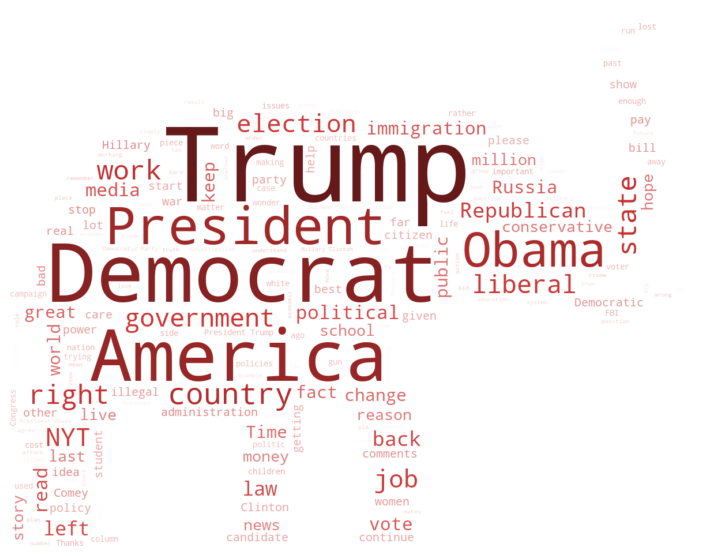

In [ ]:
#red is the color of the Republican Party 
def red_gradient(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(360, 60%%, %d%%)" % (25/(wc.words_[word]**(0.5)))
mask = np.array(Image.open("elephant.png")) #the elephant is the symbol of the republican party
#mask = np.array(Image.open("trump.png"))


stopwords = set(STOPWORDS)

#extra stop words that do not carry so much information
app_words = ['br', 'will', 'seem', 'want',"going","us","still","time","one","thank","article","know",
             "even",'thing',"something","say","now",'without','another','anyone','let','go','day',
             'well','seems','must','said','much','someone','person','yet','Mr',"every","put","find",
             'always','give','year','take','really','call','thing','sure','people','made','anything',
             'thought','got','see','way','think','least','less','good','two','look','need','many','make',
             'come','may','might','things','done','happen','part','actually','comment','become','nothing',
             'already','maybe','year','end','next','today','needs','never','blow','course','wants','instead',
             'everyone','guy','little','perhaps','s','new','better','issue','support','believe','first','use','long',
             'problem','years','point',"everything"]
stopwords.update(app_words) 

text = " ".join(comment for comment in extr_rep.commentBody)
#we regroup some close words for visualization purposes 
text=text.replace("Russian","Russia")
text=text.replace("American","America")
text=text.replace("Donald Trump","Trump")
text=text.replace("immigrant","immigration")

wc = WordCloud(width=mask.shape[1], height=mask.shape[0],max_words=2000,stopwords=stopwords,mask=mask,margin=10,random_state=3,background_color="white").generate(text)
 
plt.imshow(wc.recolor(color_func=red_gradient, random_state=3),interpolation="bilinear")
plt.axis("off")

plt.gcf().set_size_inches(20, 10)

plt.show()


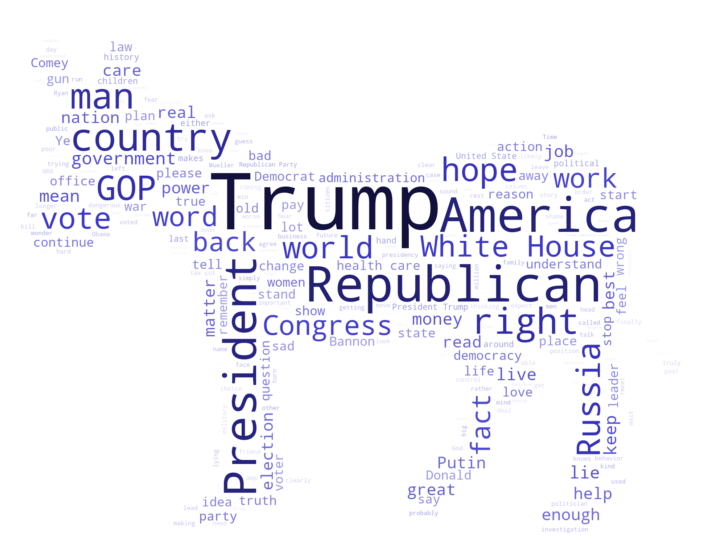

In [ ]:
#blue is the color of the democratic party
def blue_gradient(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(242, 57%%, %d%%)" % (15/(wc.words_[word]**(0.5)))
mask = np.array(Image.open("donkey.png")) #the donkey is the symbol of the democratic party
#mask = np.array(Image.open("hillary.png"))

text = " ".join(comment for comment in extr_dem.commentBody)
#we regroup some close words for visualization purposes 
text=text.replace("Russian","Russia")
text=text.replace("American","America")
text=text.replace("Donald Trump","Trump")
text=text.replace("immigrant","immigration")

wc = WordCloud(width=mask.shape[1], height=mask.shape[0],max_words=2000,stopwords=stopwords,mask=mask,margin=10,random_state=3,background_color="white").generate(text)
 
plt.imshow(wc.recolor(color_func=blue_gradient, random_state=3),interpolation="bilinear")
plt.axis("off")

plt.gcf().set_size_inches(20, 10)

plt.show()

The two clouds give interesting results. First, while the two parties' advocates obviously use a lot the words "America", "Trump" and "President", Republicans talk also a lot about Barack Obama which is not the case of the Democrats. The Trump repeatedly targeted Obama either for his political record or for his origins (Trump initiated the false controversy over his birth certificate). Thus, this strong focus on Obama on the Republican side is coherent with the political atmosphere of the very beginning of Trump era. We also note that the two camps seems to be obsessed with their opponets as the word "Republican" is dominant in the Democrat cloud and vice-versa. The two parties mention Russia quite a lot, probably referring to the investigation over Russia interferences in favour of Trump during the campaign. However the word is slightly more important in the Democrat cloud. Democrats also seem to often mention Comey who led the investigation as well as Putin who was accused of being at the origin of the interferences. The word "lie" is much more used by the Democrats than by the Republicans which is coherent as the former repeatedly accused Donald Trump of lying during his meetings. The cloud echoes the fact that Republicans seem to care much more about immigration than democrats. Finally, the word "NYT" referring to the New York Times is quite significant on the Republican cloud but does not appear on the Democratic cloud. It is likely that this is due to Republicans criticising the newspaper in their comments.

**Relations between the comments' labels and the articles they are associated with**

In this section we merge the comments we labelled with the articles they are respondiong to. This allows us to answer basic questions (link between the length of an article and the political orientation of the responses, link between the author of an article and the political orientation of the responses) as well as a broader question which is whether republican/democrat labelled commentaries tend to aggregate on articles related to certain particular topics. Indeed, we cluster the articles thanks to a Kmeans algorithm. The algorithm is fed with numeric vectors which are the average Word2Vec representation of each article. Thus, we are able to categorize the articles by themes and we put this categorization into perspective with our political labelling of the comments the articles received. 

**Basic analysis**

In [ ]:
#first we load the articles datasets
dfartJan17=pd.read_csv("ArticlesJan2017.csv")
dfartJan17["month"]=["Jan17"]*len(dfartJan17)
dfartJan18=pd.read_csv("ArticlesJan2018.csv")
dfartJan18["month"]=["Jan18"]*len(dfartJan18)
dfartFeb17=pd.read_csv("ArticlesFeb2017.csv")
dfartFeb17["month"]=["Feb17"]*len(dfartFeb17)
dfartFeb18=pd.read_csv("ArticlesFeb2018.csv")
dfartFeb18["month"]=["Feb18"]*len(dfartFeb18)
dfartApr18=pd.read_csv("ArticlesApril2018.csv")
dfartApr18["month"]=["Apr18"]*len(dfartApr18)
dfartApr17=pd.read_csv("ArticlesApril2017.csv")
dfartApr17["month"]=["Apr17"]*len(dfartApr17)
dfartMar17=pd.read_csv("ArticlesMarch2017.csv")
dfartMar17["month"]=["Mar17"]*len(dfartMar17)
dfartMar18=pd.read_csv("ArticlesMarch2018.csv")
dfartMar18["month"]=["Mar18"]*len(dfartMar18)
dfartMay17=pd.read_csv("ArticlesMay2017.csv")
dfartMay17["month"]=["May17"]*len(dfartMay17)

dfart=pd.concat([dfartJan17,dfartJan18,dfartFeb17,dfartFeb18,dfartApr18,dfartApr17,dfartMar17,dfartMar18,dfartMay17])
dfart=dfart.drop_duplicates(subset='articleID').reset_index(drop=True)

In [ ]:
dfart.head(5)

,articleID,abstract,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL,articleWordCount,month
0,58691a5795d0e039260788b9,NaN,By JENNIFER STEINHAUER,article,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",1,National,1,2017-01-01 15:03:38,Politics,The most powerful and ambitious Republican-led...,The New York Times,News,https://www.nytimes.com/2017/01/01/us/politics...,1324,Jan17
1,586967bf95d0e03926078915,NaN,By MARK LANDLER,article,Fractured World Tested the Hope of a Young Pre...,"['Obama, Barack', 'Afghanistan', 'United State...",1,Foreign,1,2017-01-01 20:34:00,Asia Pacific,A strategy that went from a “good war” to the ...,The New York Times,News,https://www.nytimes.com/2017/01/01/world/asia/...,2836,Jan17
2,58698a1095d0e0392607894a,NaN,By CAITLIN LOVINGER,article,Little Troublemakers,"['Crossword Puzzles', 'Boxing Day', 'Holidays ...",1,Games,0,2017-01-01 23:00:24,Unknown,Chuck Deodene puts us in a bubbly mood.,The New York Times,News,https://www.nytimes.com/2017/01/01/crosswords/...,445,Jan17
3,5869911a95d0e0392607894e,NaN,By JOCHEN BITTNER,article,"Angela Merkel, Russia’s Next Target","['Cyberwarfare and Defense', 'Presidential Ele...",1,OpEd,15,2017-01-01 23:30:27,Unknown,"With a friend entering the White House, Vladim...",The New York Times,Op-Ed,https://www.nytimes.com/2017/01/01/opinion/ang...,864,Jan17
4,5869a61795d0e03926078962,NaN,By JIAYIN SHEN,article,Boots for a Stranger on a Bus,"['Shoes and Boots', 'Buses', 'New York City']",0,Metro,12,2017-01-02 01:00:02,Unknown,Witnessing an act of generosity on a rainy day.,The New York Times,Brief,https://www.nytimes.com/2017/01/01/nyregion/me...,309,Jan17


In [ ]:
#we merge our labelled comments dataset with the articles
dfmerged=pd.merge(dfpolanalys[["articleID","commentID","articleWordCount","commentBody","userID","month","editorsSelection",
                              'newDesk',"recommendations","replyCount",'timespeople','trusted','label']],
                  dfart[["articleID","byline","headline","keywords","snippet"]],on=['articleID'],how='inner')

In [ ]:
len(dfpolanalys)

58318

In [ ]:
#around 700 commentaries are lost (wrong IDs) 
len(dfmerged)

57590

In [ ]:
dfmerged.head(10)

,articleID,commentID,articleWordCount,commentBody,userID,month,editorsSelection,newDesk,recommendations,replyCount,timespeople,trusted,label,byline,headline,keywords,snippet
0,58691a5795d0e039260788b9,20968055.0,1324.0,I think the Republicans deserve every bit of c...,11224991.0,Jan17,0,National,23.0,3.0,1.0,0.0,0,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
1,58691a5795d0e039260788b9,20968162.0,1324.0,A sitting President's 'policies may be in peri...,69482944.0,Jan17,0,National,7.0,0.0,1.0,0.0,0,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
2,58691a5795d0e039260788b9,20968262.0,1324.0,I believe we will see how serious the GOP is a...,18862124.0,Jan17,0,National,8.0,0.0,1.0,0.0,1,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
3,58691a5795d0e039260788b9,20967883.0,1324.0,"The reek of GOP retribution is pungent, indica...",76243499.0,Jan17,0,National,63.0,2.0,1.0,0.0,1,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
4,58691a5795d0e039260788b9,20967781.0,1324.0,"When all is said and done or undone, will Puti...",67896430.0,Jan17,0,National,6.0,1.0,1.0,0.0,1,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
5,58691a5795d0e039260788b9,20967590.0,1324.0,One difference between the Democrats being obs...,17008759.0,Jan17,0,National,15.0,0.0,1.0,0.0,0,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
6,58691a5795d0e039260788b9,20966253.0,1324.0,ONE PARTY RULE...the warstate... and I'm a Wyo...,29907180.0,Jan17,0,National,6.0,2.0,1.0,0.0,1,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
7,58691a5795d0e039260788b9,20967126.0,1324.0,"A beautiful headline, unspeakable just 2 month...",70068458.0,Jan17,0,National,7.0,2.0,1.0,0.0,0,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
8,58691a5795d0e039260788b9,20967166.0,1324.0,It is absolutely cruel to repeal the ACA and k...,449122.0,Jan17,0,National,7.0,6.0,1.0,0.0,1,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...
9,58691a5795d0e039260788b9,20967051.0,1324.0,Professional politicians in both parties faile...,67791470.0,Jan17,0,National,2.0,0.0,1.0,0.0,1,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law...",The most powerful and ambitious Republican-led...


In [ ]:
#for every article we compute the number of republican/democrat commentaries it received
dem=[1 if dfmerged['label'][k]==1 else 0 for k in range(len(dfmerged))]
rep=[0 if dfmerged['label'][k]==1 else 1 for k in range(len(dfmerged))]
dfmerged["dem"]=dem
dfmerged["rep"]=rep
polarisation_by_article=dfmerged.groupby("articleID")[["dem","rep"]].sum()
polarisation_by_article['articleID']=polarisation_by_article.index
polarisation_by_article.columns=(["nb_dem_com","nb_rep_com","articleID"])
polarisation_by_article=polarisation_by_article.reset_index(drop=True)

#we match the information we just computed with the main article characteristics
dfartpolar=pd.merge(dfart[["articleID","byline","headline","keywords","snippet","articleWordCount"]],polarisation_by_article,on=['articleID'],how='inner')

#we discard the observations that do not have keywords as they will be necessary for our analysis
dfartpolar = dfartpolar.loc[dfartpolar['keywords'] != '[]'].reset_index(drop=True)
#keywords cleaning
dfartpolar['keywords'] = dfartpolar['keywords'].replace(r'\[\'|\'\]', '', regex=True).str.split(r'\',\s\'')

#we compute the proportion of republican commentaries for every article
dfartpolar["nb_comments"]=dfartpolar["nb_dem_com"]+dfartpolar["nb_rep_com"]
dfartpolar['%rep_comments']=dfartpolar['nb_rep_com']/dfartpolar["nb_comments"]

In [ ]:
dfartpolar.head(10)

,articleID,byline,headline,keywords,snippet,articleWordCount,nb_dem_com,nb_rep_com,nb_comments,%rep_comments
0,58691a5795d0e039260788b9,By JENNIFER STEINHAUER,G.O.P. Leadership Poised to Topple Obama’s Pi...,"[United States Politics and Government, Law an...",The most powerful and ambitious Republican-led...,1324,15,8,23,0.347826
1,586a0d8795d0e039260789b3,By THE EDITORIAL BOARD,Sprint and Mr. Trump’s Fictional Jobs,"[Trump, Donald J, Son, Masayoshi, Wireless Com...","The emerging, and dangerous, new form of crony...",557,10,2,12,0.166667
2,586a0d8795d0e039260789b6,By PAUL KRUGMAN,America Becomes a Stan,"[Trump, Donald J, United States Politics and G...",Rule of law is for the little people.,784,7,1,8,0.125000
3,586afcfe95d0e03926078aee,By ABBY GOODNOUGH and ROBERT PEAR,Health Reform Could Outlast Repeal Efforts,"[Health Insurance and Managed Care, Patient Pr...",A transformation of the delivery of health car...,3361,5,0,5,0.000000
4,586b037e95d0e03926078af5,By THE EDITORIAL BOARD,"Mr. Trump, Bureaucracy Apprentice","[Government Employees, United States Politics ...",Mr. Trump is already making big mistakes by un...,677,13,1,14,0.071429
5,586b0a7495d0e03926078b03,By ERIC LIPTON,House G.O.P. Votes to Gut an Office Reviewing ...,"[House of Representatives, House Committee on ...",The move by emboldened Republicans on the eve ...,1152,59,10,69,0.144928
6,586b10be95d0e03926078b11,"By EZRA LEVIN, LEAH GREENBERG and ANGEL PADILLA",Lessons From the Tea Party,"[Tea Party Movement, Democratic Party, House o...",It’s a simple playbook: organize locally and p...,875,17,9,26,0.346154
7,586b5ef495d0e03926078b68,By DAVID BROOKS,The Snapchat Presidency,"[Trump, Donald J, United States Politics and G...",The next occupant (at least part time) of the ...,805,25,5,30,0.166667
8,586bc2d995d0e03926078c1f,By ERIC LIPTON and MATT FLEGENHEIMER,House G.O.P. Abandons Bid to Stifle Ethics Office,"[United States Politics and Government, House ...","Lawmakers, facing a storm of bipartisan critic...",1305,99,11,110,0.100000
9,58705c7995d0e0392607972d,By GAIL COLLINS,Arms and the Trump,"[Gun Control, Murders, Attempted Murders and H...","Another day, another terrible shooting.",823,10,2,12,0.166667


The proportion of Republican comments is an indicator reflecting whether Republicans are interested about the article (positively or negatively). This number must be put into perspective with the fact that for our entire labelling we had around 22% republican comments. Thus, the articles receiving a proportion of Republican comments above that number are articles that are proportionnally more "attractive to" republicans than to democrats. "Attractive" is neutral here, it only means that the article receives a reaction, this reaction can be either support or opposition.


In [ ]:
#we have roughly 2 800 articles for the analysis
len(dfartpolar)

2796

Now we can run some basic analysis using the 22% threshold mentionned earlier. With this rule it appears the number of articles "attractive to" republicans is larger than the number of articles attractive to democrats. iI can seem inconsistent with the fact we have only 22% republicans comments in our dataset. This is explained by the fact that articles "attractive to" republicans receive less commentaries than their democrat counterparts.


In [ ]:
test_rep=dfartpolar.loc[dfartpolar['%rep_comments']>0.22].reset_index(drop=True)
test_dem=dfartpolar.loc[dfartpolar['%rep_comments']<=0.22].reset_index(drop=True)

In [ ]:
len(test_rep)

1468

In [ ]:
len(test_dem)

1328

These two datasets we just created gather respectively the "Republican-attractive" and the "Democrat-attractive" articles. An article is considered to be "Republican-attractive" if the share of its comments labelled Republicans is larger than the share of Reuplicans comments we have on our entire dataset (25%). This does not mean that the article is Republican-friendly it only means it seems to attract Republican-leaning comments.

In [ ]:
print("Total number of comments for the republican-attractive articles : ",sum(test_rep["nb_comments"]))
print("Total number of comments for the democrat-attractive articles : ",sum(test_dem["nb_comments"]))

Total number of comments for the republican-attractive articles :  24603
Total number of comments for the democrat-attractive articles :  32836


In [ ]:
print("Average length of the republican-attractive articles : ",np.mean(test_rep["articleWordCount"]))
print("Average length of the democrat-attractive articles : ",np.mean(test_dem["articleWordCount"]))

Average length of the republican-attractive articles :  1131.5933242506812
Average length of the democrat-attractive articles :  1083.515813253012


There is no substantial difference between the two sort of articles in term of length.


In [ ]:
test_dem.byline.value_counts().head(15)

By THE EDITORIAL BOARD    125
By PAUL KRUGMAN            60
By GAIL COLLINS            45
By FRANK BRUNI             37
By CHARLES M. BLOW         36
By ROSS DOUTHAT            30
By NICHOLAS KRISTOF        28
By DAVID BROOKS            28
By ROGER COHEN             25
By THOMAS L. FRIEDMAN      20
By BRET STEPHENS           20
By TIMOTHY EGAN            19
By MICHELLE GOLDBERG       17
By PETER BAKER             17
By MAUREEN DOWD            16
Name: byline, dtype: int64

In [ ]:
test_rep.byline.value_counts().head(15)

By THE EDITORIAL BOARD    122
By NICHOLAS KRISTOF        43
By PAUL KRUGMAN            43
By DAVID BROOKS            42
By ROSS DOUTHAT            34
By DAVID LEONHARDT         31
By ROGER COHEN             31
By FRANK BRUNI             31
By THOMAS B. EDSALL        25
By CHARLES M. BLOW         24
By LIZ SPAYD               21
By BRET STEPHENS           19
By THOMAS L. FRIEDMAN      17
By MICHELLE GOLDBERG       17
By GAIL COLLINS            11
Name: byline, dtype: int64

In [ ]:
len(dfartpolar.loc[dfartpolar['byline']=="By LIZ SPAYD"])

27

The distinction between our two datasets in terms of authors is interesting. Paul Krugman and Gail Collins are notoriously staunch Trump opponents. They are among the two most profilif authors of "Democrat-attractive" articles. David Brooks and Ross Douthat are among the most conservative columnists of the NYT. They are among the two most profilif authors of "Republican-attractive" articles.
Liz Spayd was quite controversial and has been sacked by the NYT, she was accused by some of complacency towards the alt-right. 21 out of her 27 articles are considered by our labelling and our method of article categorization to be "Republican-attractive". 


Now let's look at the most frequent keywords for our two categories of articles.

In [ ]:
def most_frequent_keywords(corpus,nb):
    keywords=[]
    for words in corpus:
        keywords+=words
    counts = Counter(keywords)
    return(counts.most_common(nb))

In [ ]:
print('Republican-attractive articles top keywords:')
most_frequent_keywords(test_rep.keywords,5)

Republican-attractive articles top keywords:


[('Trump, Donald J', 670),
 ('United States Politics and Government', 618),
 ('Republican Party', 179),
 ('Democratic Party', 141),
 ('Immigration and Emigration', 120)]

In [ ]:
print('Democrat-attractive articles top keywords:')
most_frequent_keywords(test_dem.keywords,5)

Democrat-attractive articles top keywords:


[('Trump, Donald J', 869),
 ('United States Politics and Government', 787),
 ('Republican Party', 191),
 ('United States International Relations', 154),
 ('Russian Interference in 2016 US Elections and Ties to Trump Associates',
  115)]

The keyword analysis is coherent with what we observed with the wordclouds. Republicans seems to be more interested than Democrats in immigration-related topics while the opposite is true for Russia-related topics.

**Clustering**

For this part we first need to gather the text data for every article then clean it and translate it into numeric vectors, finally we will apply the Kmeans algorithm.
Our text data for every article is going to be the concatenation of the headline and the snippet. Choosing only one of the two would have given too short and not explicit enough data. As we are going to use the word2vec model we built for the commentaries analysis, it was not relevant to use the keywords because word2vec is based around the distribution hypothesis so it needs words put into some context not just series of unrelated words. We keep the keywords for the clusters analysis.

In [ ]:
#text data
text=[dfartpolar['headline'][k]+' '+dfartpolar['snippet'][k] for k in range(len(dfartpolar))]
dfartpolar['text']=text
dfartpolar['text'][18]

'A Bond Over Bucking the Establishment An alliance with Donald J. Trump has paid off for Mr. Sessions in a fashion that few who know him ever imagined: Within days, he could be confirmed as attorney general.'

In [ ]:
#cleaning functions

def tokenize_articles(corpus,countmode=False):
  tokenizer = TweetTokenizer()
  tokenized_articles = []
  corpus=corpus.array
  for sample in tqdm(corpus):
    tokens = tokenizer.tokenize(sample)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_at(tokens)
    tokens = remove_short(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokens= [porter_stemmer.stem(word) for word in tokens] #stemming
    if not countmode:
      tokenized_articles.append(tokens)
    else:
      tokenized_articles+=tokens
  return tokenized_articles

def clean_corpusart(corpus, threshold=1000):
  tokenized_sentences = tokenize_articles(corpus,countmode=False)
  tokenized_sentences = remove_stopwords(tokenized_sentences,stopwords)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  phraser = Phraser(phrases)
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus

In [ ]:
#stopwords removal

cleanedart_to_count = tokenize_articles(dfartpolar.text,countmode=True)

counts_art = Counter(cleanedart_to_count)
print(counts_art)

#as stopwords we select the words that appear only once in the entire dataset as well as the words that appear the most but 
#do not carry any information such as "the"
#both "president" and "trump" appear also a lot but we choose to keep them
stopwords1 = [token for token in np.unique(cleanedart_to_count) if counts_art[token]==1]
stopwords2 = [token for token in np.unique(cleanedart_to_count) if counts_art[token]>201]
stopwords2.remove('trump')
stopwords2.remove('presid')
stopwords=stopwords1+stopwords2

100%|██████████| 2796/2796 [00:00<00:00, 2882.53it/s]


Counter({'the': 4168, 'to': 1913, 'of': 1697, 'and': 1231, 'in': 1206, 'trump': 1131, 'for': 776, 'is': 773, 'on': 764, 'presid': 693, 'it': 580, 'that': 534, 'with': 419, 'as': 387, 'hi': 369, 'ar': 366, 'be': 360, 'an': 317, 'but': 316, 'ha': 304, 'he': 278, 'at': 272, 'not': 270, 'have': 256, 'about': 251, 'from': 248, 'wa': 244, 'by': 241, 'new': 240, 'what': 232, 'hous': 225, 'who': 222, 'will': 219, 'we': 219, 'thei': 203, 'republican': 201, 'can': 192, 'state': 188, 'mr': 186, 'more': 172, 'how': 168, 'their': 159, 'white': 154, 'sai': 145, 'american': 144, 'democrat': 142, 'up': 141, 'would': 139, 'peopl': 133, 'thi': 133, 'over': 132, 'america': 129, 'you': 129, 'time': 128, 'polit': 128, 'than': 126, 'us': 125, 'after': 125, 'donald': 123, 'our': 122, 'when': 121, 'health': 118, 'into': 117, 'or': 114, 'now': 114, 'plan': 112, 'nation': 112, 'like': 111, 'senat': 110, 'do': 110, 'immigr': 110, 'year': 109, 'could': 109, 'said': 109, 'some': 109, 'make': 108, 'administr': 108,

In [ ]:
cleaned_text=clean_corpusart(dfartpolar.text, threshold = 1000)

100%|██████████| 2796/2796 [00:00<00:00, 3267.20it/s]


In [ ]:
cleaned_text[0]

['leadership',
 'pois',
 'obama',
 'pillar',
 'most',
 'power',
 'ambiti',
 'republican-l',
 'congress',
 '20',
 'year',
 'plan',
 'quick',
 'action',
 'sever',
 'prioriti',
 'most',
 'notabl',
 'clear',
 'path',
 'repeal',
 'presid',
 'obama',
 'health',
 'care',
 'law']

In [ ]:
#we use the word2vec model that we trained previously
#for every article we take the average of its words embeddings 
avg_embeddings=[]
for k in range(len(cleaned_text)):
    new_avg_embedding=np.mean([comnyt_wv[word] for word in cleaned_text[k] if word in comnyt_wv], axis=0)
    new_avg_embedding=list(new_avg_embedding)
    avg_embeddings.append(new_avg_embedding)

X=np.array(avg_embeddings)

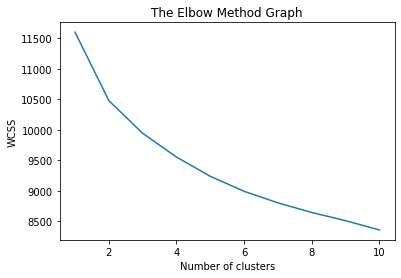

In [ ]:
#elbow method to decide the number of clusters we should take

wcss=[]
for i in range(1,11): 
     kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
     kmeans.fit(X)
     wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
#the choice with the elbow method is not clear in our case
#we select the number of clusters that has the more sense 

clustering = KMeans( max_iter=300, n_clusters=4)
clustering.fit(X)
clustlabels=list(clustering.predict(X))
dfartpolar['cluster']=clustlabels

Now that every article has been assigned a cluster. The idea is to plot the clusterisation on a 2D graph using a PCA in order to reduce the dimensions of our vectors. We will first plot the articles coloring them depending on their clusters then depending on their political label (above 22% Republican comments an article is labelled Republican-attractive). As a result we will have a visual indication about the content of the clusters.

In [ ]:
#we use a PCA so that we can plot our vectors on a 2D space

pca = PCA(n_components=2, random_state=0)
X_reduced = pca.fit_transform(X)
dfartpolar['X']=list(X_reduced[:,0])
dfartpolar['Y']=list(X_reduced[:,1])

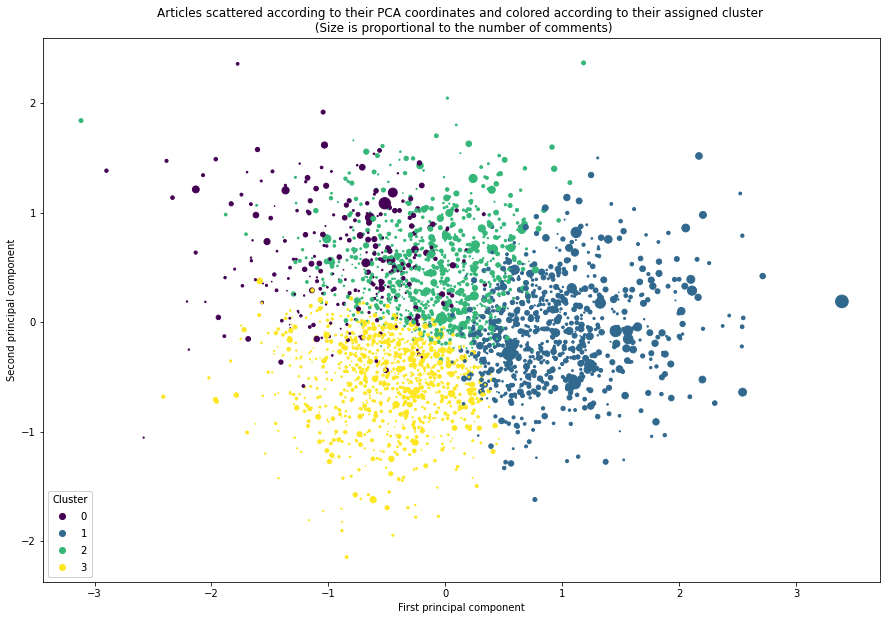

In [ ]:
#plot of the articles coordinates colored depending on their cluster
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(dfartpolar['X'], dfartpolar['Y'], c=dfartpolar['cluster'],s=dfartpolar["nb_comments"]/2)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Cluster")
ax.add_artist(legend1)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Articles scattered according to their PCA coordinates and colored according to their assigned cluster \n (Size is proportional to the number of comments)'
          )
plt.show()

In [ ]:
dfartpolar.cluster.value_counts()

3    890
2    835
1    815
0    256
Name: cluster, dtype: int64

In [ ]:
#we create datasets at the cluster level
cluster0=dfartpolar.loc[dfartpolar['cluster']==0].reset_index(drop=True)
cluster2=dfartpolar.loc[dfartpolar['cluster']==2].reset_index(drop=True)
cluster3=dfartpolar.loc[dfartpolar['cluster']==3].reset_index(drop=True)
cluster1=dfartpolar.loc[dfartpolar['cluster']==1].reset_index(drop=True)
cluster4=dfartpolar.loc[dfartpolar['cluster']==4].reset_index(drop=True)

In [ ]:
#function used to tweak a colormap 
#source : https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib/20528097
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


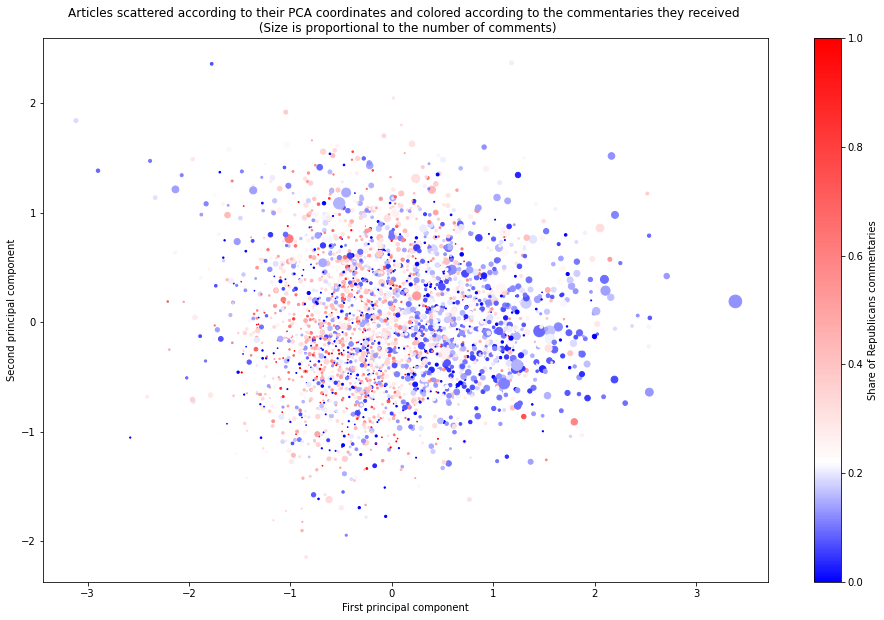

In [ ]:
#now we plot the same coordinates but we change the colors to see how the clusterisation interacts with the labellisation
#blue is democrat and red is republican

newcmap=shiftedColorMap(matplotlib.cm.bwr, start=0, midpoint=0.22, stop=1, name='shiftedcmap')
fig, ax = plt.subplots(figsize=(16.25, 10))

scatter = ax.scatter(dfartpolar['X'], dfartpolar['Y'], c=dfartpolar["%rep_comments"],s=dfartpolar["nb_comments"]/2,
                     cmap=newcmap)

cbar=plt.colorbar(scatter)
cbar.set_label('Share of Republicans commentaries')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Articles scattered according to their PCA coordinates and colored according to the commentaries they received \n (Size is proportional to the number of comments)'
          )
plt.show()

The first cluster is well reconstructed by the political categorization. Indeed we see that the vast majority of the articles at the right of the picture are blue, thus considered to be "Democrat-attractive". Clusters 0, 2 and 3 however appear to be a mixture of Republican and Democrat-attractive commentaries. Now let's look at the clusters in detail.

In [ ]:
#we compute some indicators at the cluster level
polarisation_by_cluster=dfartpolar.groupby('cluster').agg({'nb_dem_com':'sum', 
                         'nb_rep_com':'sum', 
                         '%rep_comments':'mean'})

In [ ]:
polarisation_by_cluster

,nb_dem_com,nb_rep_com,%rep_comments
cluster,,,
0,4741,1303,0.255010
1,20490,4269,0.191474
2,10986,4142,0.303151
3,8316,3192,0.313228


We therefore have the confirmation than cluster 1 is mostly democrat.

In [ ]:
#as the first two keywords are common for all clusters, we plot the first 12 keywords instead of first 10
most_frequent_keywords(cluster3.keywords,12)

[('Trump, Donald J', 235),
 ('United States Politics and Government', 218),
 ('Women and Girls', 72),
 ('Blacks', 59),
 ('Colleges and Universities', 49),
 ('School Shootings and Armed Attacks', 47),
 ('Gun Control', 45),
 ('Republican Party', 44),
 ('Demonstrations, Protests and Riots', 43),
 ('Parkland, Fla, Shooting (2018)', 42),
 ('Education (K-12)', 36),
 ('United States', 35)]

In [ ]:
most_frequent_keywords(cluster2.keywords,12)

[('Trump, Donald J', 440),
 ('United States Politics and Government', 423),
 ('Republican Party', 143),
 ('Democratic Party', 105),
 ('Immigration and Emigration', 92),
 ('Senate', 89),
 ('United States International Relations', 79),
 ('House of Representatives', 70),
 ('United States Defense and Military Forces', 54),
 ('Politics and Government', 51),
 ('Supreme Court (US)', 51),
 ('Illegal Immigration', 50)]

In [ ]:
most_frequent_keywords(cluster1.keywords,12)

[('Trump, Donald J', 702),
 ('United States Politics and Government', 605),
 ('Russia', 129),
 ('United States International Relations', 125),
 ('Russian Interference in 2016 US Elections and Ties to Trump Associates',
  122),
 ('Presidential Election of 2016', 116),
 ('Federal Bureau of Investigation', 101),
 ('Republican Party', 87),
 ('Comey, James B', 64),
 ('Mueller, Robert S III', 62),
 ('Special Prosecutors (Independent Counsel)', 58),
 ('Justice Department', 52)]

In [ ]:
most_frequent_keywords(cluster0.keywords,12)

[('Trump, Donald J', 162),
 ('United States Politics and Government', 159),
 ('Republican Party', 96),
 ('Health Insurance and Managed Care', 95),
 ('Patient Protection and Affordable Care Act (2010)', 78),
 ('House of Representatives', 70),
 ('Senate', 44),
 ('Federal Budget (US)', 38),
 ('Law and Legislation', 28),
 ('Ryan, Paul D Jr', 24),
 ('Democratic Party', 23),
 ('Medicaid', 20)]

Looking at the keywords we understand why the graphic representation identified the cluster 1 as a cluster gathering Democrat-attractive articles. The most frequent keywords of the articles of this cluster reveal it gathers the articles dealing with the investigation on the Russian interferences in the 2016 elections (Mueller and Comey led the investigations). The accusation was led by Democrats and directed against Trump so it is coherent that the articles of this cluster are mostly Democrat-attractive articles.

Cluster 0 gathers more diversed articles but the dominant theme is health insurance with three keywords related to it appearing in the top 10 (excluding the first two keywords that are common to all the clusters. This cluster has a sort of intermediate position in our classification as it is not the most Democrat neither the most Republican. Thus health insurance can be viewed as a topic interesting both parties depsite the fact they have diverging opinions about it.

Clusters 2 and 3 are the most Republicans. It is therefore no surprise that cluster 2 is the cluster that gathers the most articles dealing with immigration as well as military forces which are traditionnally Republican themes. Many articles regarding mass shootings and gun control are gathered in cluster 3. We know that Republicans are usually staunch opponents of gun control so it is coherent that this theme attracts more of their responses than others. Racial justice seems also to be one of the themes of cluster 3 with the keywords "Blacks" and "Demonstrations, Protests and Riots". 

Despite being very general, our analysis of the language elements of the two parties' advocates (with the wordclouds) as well as their topics of interests (with the clusterisation) allows to reflect quite well the polarisation of the American political scene.

# Comparison of the two labellings


## Cleaning the data

In [ ]:
# Let's load the data created in the first part
dfanalysis = pd.read_csv("dfpolanalys.csv")

In [ ]:
dfanalysis.head()

,Unnamed: 0,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,typeOfMaterial,month,label,data,raw_label
0,0,1483400582,58691a5795d0e039260788b9,1324.0,I think the Republicans deserve every bit of c...,20968055.0,20968055.0,<br/>,comment,1.483395e+09,1.0,0,0.0,National,0.0,NaN,20968055.0,https://graphics8.nytimes.com/images/apps/time...,1.0,23.0,NaN,3.0,NaN,Politics,0,approved,1.0,0.0,1483400582,Kevin,11224991.0,Tokyo,NaN,NaN,News,Jan17,0,analysis,[0.10359368]
1,1,1483400090,58691a5795d0e039260788b9,1324.0,A sitting President's 'policies may be in peri...,20968162.0,20968162.0,<br/>,comment,1.483396e+09,1.0,0,0.0,National,0.0,NaN,20968162.0,https://s3.amazonaws.com/pimage.timespeople.ny...,1.0,7.0,NaN,0.0,NaN,Politics,0,approved,1.0,0.0,1483400090,to make waves,69482944.0,Charlotte,NaN,NaN,News,Jan17,0,analysis,[0.14389268]
2,2,1483398911,58691a5795d0e039260788b9,1324.0,I believe we will see how serious the GOP is a...,20968262.0,20968262.0,<br/>,comment,1.483397e+09,1.0,0,0.0,National,0.0,NaN,20968262.0,https://graphics8.nytimes.com/images/apps/time...,1.0,8.0,NaN,0.0,NaN,Politics,0,approved,1.0,0.0,1483398911,gratis,18862124.0,Colorado,NaN,NaN,News,Jan17,1,analysis,[0.7080349]
3,3,1483392637,58691a5795d0e039260788b9,1324.0,"The reek of GOP retribution is pungent, indica...",20967883.0,20967883.0,<br/>,comment,1.483392e+09,1.0,0,0.0,National,0.0,NaN,20967883.0,https://graphics8.nytimes.com/images/apps/time...,1.0,63.0,NaN,2.0,NaN,Politics,0,approved,1.0,0.0,1483392637,LC,76243499.0,France,NaN,NaN,News,Jan17,1,analysis,[0.97886014]
4,4,1483392010,58691a5795d0e039260788b9,1324.0,"When all is said and done or undone, will Puti...",20967781.0,20967781.0,<br/>,comment,1.483390e+09,1.0,0,0.0,National,0.0,NaN,20967781.0,https://graphics8.nytimes.com/images/apps/time...,1.0,6.0,NaN,1.0,NaN,Politics,0,approved,1.0,0.0,1483392010,uga muga,67896430.0,Miami fl,NaN,NaN,News,Jan17,1,analysis,[0.8702391]


We clean the data the same way we did to create the first database. 

In [ ]:
cleaned_comnyt = clean_corpus(dfanalysis.commentBody, threshold = 1000)

100%|██████████| 58318/58318 [00:21<00:00, 2659.71it/s]


In [ ]:
len(dfanalysis), len(cleaned_comnyt)

(58318, 58318)

In [ ]:
cleaned_comnyt[:2]

[['think',
  'republican',
  'deserv',
  'everi',
  'bit',
  'cooper',
  'gave',
  'obama',
  'democrat',
  'over',
  'past',
  'year'],
 ['sit',
  'presid',
  'polici',
  'mai',
  'peril',
  'new',
  'administr',
  'prepar',
  'take',
  'job',
  'almost',
  'though',
  'not',
  'even',
  'fair',
  'anymor',
  'some',
  'peopl',
  'malign',
  'year',
  'by',
  'continu',
  'adher',
  'silli',
  'headlin',
  'uphold',
  'elect',
  'new',
  'person']]

We will now apply the models we trained on the SST to the NYT comments.

## Word2Vec

In [ ]:
# First we create our Word2Vec vector
comnyt = Word2Vec(cleaned_comnyt, size=100, window=5, min_count=3, workers=cpu, sg=1) #we use skip-gram
comnyt.train(cleaned_comnyt, total_examples=len(cleaned_comnyt), epochs=10)
comnyt_wv = comnyt.wv

In [ ]:
X= tokens2vectors(comnyt_wv, cleaned_comnyt)

Y=[]
index_com = 0
ComBody = []
Article_wv = []
Dem_Rep = []
for x in list(X):
    try: 
        Y.append(list(x))
        ComBody.append(dfanalysis.commentBody[index_com])
        Article_wv.append(dfanalysis.articleID[index_com])
        Dem_Rep.append(dfanalysis.label[index_com])
        index_com+=1
    except : 
        index_com+=1
        pass
    
comnyt_word2vec= pd.DataFrame(Y,columns=[str(x) for x in range(len(Y[0]))])

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


In [ ]:
len(ComBody), len(comnyt_word2vec), len(Article_wv), len(Dem_Rep)

(58227, 58227, 58227, 58227)

In [ ]:
tree_predictions_word2vec = tree_decision_wv.predict(comnyt_word2vec)
rf_predictions_word2vec = rf_decision_wv.predict(comnyt_word2vec)

In [ ]:
random.seed(12)
comandlabel_wv = pd.DataFrame({'articleID' : Article_wv, 'Comment' : ComBody, 'Dem_Rep' : Dem_Rep, 'LabelPredictionTree' : list(tree_predictions_word2vec), 'LabelPredictionRF' : list(tree_predictions_word2vec)})
comandlabel_wv.iloc[random.sample(range(len(comandlabel_wv)), 5)]

,articleID,Comment,Dem_Rep,LabelPredictionTree,LabelPredictionRF
31101,5adfb5cd068401528a2aa78d,"""Israel’s Got Its Own Refugee Dilemma""- only x...",1,0,0
17628,58b0894195d0e0247463875e,"Roy Cohn was an early mentor for Trump, so it ...",1,0,0
43088,58cbec937c459f247805c6e6,I know how Trump's staff must feel. My dog te...,1,0,0
34677,59013d9a7c459f24986dc521,Call me crazy but I'm a middle class person wh...,1,0,0
43673,58d053d97c459f247805cedc,Possibly the only true thing that Trump has ev...,0,1,1


What we observe with this random extract of labelled comments is that, apparently, Democrats tend to write positive comments (the new 0 are associated with Democrats labelled 1).

In [ ]:
# We "quantitatively" evaluate our models by comparing with the labels created in the first part
prf_score_tree = list(precision_recall_fscore_support(Dem_Rep, tree_predictions_word2vec, average = 'binary'))
prf_score_tree.append(accuracy_score(Dem_Rep, tree_predictions_word2vec))
prf_score_rf = list(precision_recall_fscore_support(Dem_Rep, rf_predictions_word2vec, average = 'binary'))
prf_score_rf.append(accuracy_score(Dem_Rep, rf_predictions_word2vec))

results = pd.DataFrame(index = ['Decision Tree', 'Random Forest'], 
          columns = ['Precision', 'Recall', 'F1 score', 'support', 'Accuracy']
          )
results.loc['Decision Tree'] = prf_score_tree
results.loc['Random Forest'] = prf_score_rf

In [ ]:
results

,Precision,Recall,F1 score,support,Accuracy
Decision Tree,0.772842,0.434997,0.55667,None,0.463187
Random Forest,0.788079,0.487664,0.6025,None,0.501451


Here, unlike for the qualitative comparison, we see that we have an accuracy of 50% with the Random Forest. It means that we have a half-half repartition of positive and negative comments for both Democrats and Republicans. This is not that much surprising since articles must cover many topics, many of them certainly gathering mixed feelings from the readers. We still obtain a F1-score of 60%, meaning it is probably possible to evaluate the political orientation of commentators thanks to this model.

## TF-IDF

In [ ]:
# Formatage de la base pour la méthode TF-IDF
corpus=cleaned_comnyt
corpus_test=[]
for sent in corpus: 
    sentence=''
    for word in sent:
        sentence = sentence+' '+word
    corpus_test.append(sentence)

In [ ]:
tfidf = TfidfVectorizer(max_features = 100) 
tfidf.fit(corpus_test)
comnyt_tfidf = tfidf.transform(corpus_test)
comnyt_tfidf.shape

(58318, 100)

In [ ]:
tree_predictions_tfidf = tree_decision_tfidf.predict(comnyt_tfidf)
rf_predictions_tfidf = rf_decision_tfidf.predict(comnyt_tfidf)

In [ ]:
random.seed(12)
comandlabel_tfidf = pd.DataFrame({'articleID' :  dfanalysis.articleID, 'Comment' : dfanalysis.commentBody, 'Dem_Rep': dfanalysis.label, 'LabelPredictiontree' : list(tree_predictions_tfidf), 'LabelPredictionRF' : list(rf_predictions_tfidf)})
comandlabel_tfidf.iloc[random.sample(range(len(comandlabel_tfidf)), 5)]

,articleID,Comment,Dem_Rep,LabelPredictiontree,LabelPredictionRF
31101,5adf6ddf068401528a2aa6b7,"The ""blue wave"" is going to get swamped by a r...",0,1,1
17628,58b050c295d0e0247463867b,It's not clear whether this study measured com...,1,0,0
43088,58cbec937c459f247805c6e6,So the obvious...... Isn't this pushing away a...,1,0,1
34677,590117837c459f24986dc4ca,How much richer do they need to be? It's ludic...,1,0,0
43673,58cfc89c7c459f247805cd37,Investigate . . . That's what the I in FBI sta...,0,1,1


Like we observe with the *Word2Vec* representation, Democrats seem to send positive comments.

In [ ]:
prf_score_tree = list(precision_recall_fscore_support(comandlabel_tfidf.Dem_Rep, tree_predictions_tfidf, average = 'binary'))
prf_score_tree.append(accuracy_score(comandlabel_tfidf.Dem_Rep, tree_predictions_tfidf))
prf_score_rf = list(precision_recall_fscore_support(comandlabel_tfidf.Dem_Rep, rf_predictions_tfidf, average = 'binary'))
prf_score_rf.append(accuracy_score(comandlabel_tfidf.Dem_Rep, rf_predictions_tfidf))

results = pd.DataFrame(index = ['Decision Tree', 'Random Forest'], 
          columns = ['Precision', 'Recall', 'F1 score', 'support', 'Accuracy']
          )
results.loc['Decision Tree'] = prf_score_tree
results.loc['Random Forest'] = prf_score_rf

In [ ]:
results

,Precision,Recall,F1 score,support,Accuracy
Decision Tree,0.780711,0.578245,0.664396,None,0.54719
Random Forest,0.779266,0.602292,0.679444,None,0.559484


This time, we get a 68% F1-score, which is quite high and encouraging to label the political orientation of readers using their comments and models trained on the SST database.

## LSTM (SST-Trained)

Now we try to label the comments thanks to our most performing model on the SST: the LSTM neural network (with the default embedding method). 

In [ ]:
# We format the data in the adequate shape
comnyt_data = list(zip(cleaned_comnyt, dfanalysis.label))

In [ ]:
# We evaluate the LSTM model with our NYT comments
ground_truth, scores = [], []
with torch.no_grad():
  for sentence, tag in comnyt_data:
    if len(sentence)>0 :
      sentence_in = prepare_sequence(sentence, word_to_ix)
      ground_truth.append(tag)
      tag_scores = model(sentence_in)
      scores.append(torch.mean(tag_scores.squeeze(0)[:, 1]).item())

print("F1 score", precision_recall_fscore_support(ground_truth, np.array(scores)>0.5,average = 'binary')[2])

F1 score 0.8710766246362754


We obtain a F1-score of 87%! This shows a very convincing labelling of the comments from sentiment to political orientation. Indeed, the positive/negative labels are quite comparable with the Democrat/Republican labels. The fact that there is such a similarity is also interesting because it seems that this time Democrats are mostly labelled with negative feelings (1).

In [ ]:
# Qualitative evaluation
PredLSTM = list(1*(np.array(scores)>0.5))

In [ ]:
ComBody = []
Article = []
Dem_Rep = []
for i in range(len(cleaned_comnyt)):
    if len(cleaned_comnyt[i])>0 :
        ComBody.append(dfanalysis.commentBody[i])
        Article.append(dfanalysis.articleID[i])
        Dem_Rep.append(dfanalysis.label[i])

In [ ]:
comandlabel_LSTM = pd.DataFrame({'articleID': Article, 'Comment' : ComBody, 'Dem_Rep' : Dem_Rep, 'LSTM Predictions' : PredLSTM})

In [ ]:
comandlabel_LSTM.iloc[random.sample(range(len(comandlabel_LSTM)), 5)]

,articleID,Comment,Dem_Rep,LSTM Predictions
45258,5aa07926410cf7000162f342,"From an unrelated article, I learned that Trum...",0,1
56645,5925fcfa7c459f24986e1826,I wish the New York Times had been so concerne...,0,1
39417,58c04f2f7c459f247962df74,AARP is against this bill too.,0,1
14918,58a22c7f95d0e0247463639e,Fantastic article and new guidelines.,0,1
36581,58f70ff77c459f24986dadb3,"Again, Trump probably has shares or some other...",1,1


The qualitative evaluation shows us a different side of this model: it seems that the labelling is not that efficient, mostly labelling with 1, which is indeed similar to the proportion of Democrats in the database, but not necesseraly useful in our situation. 

In [ ]:
np.sum(PredLSTM)/len(PredLSTM)*100

99.58782008346644

We see that 99.6% of the database has been labelled with unhappy feelings. Here we see that, as we were warned beforehand, the SST dataset might not be ideal to classify political views considering the difference in the vocabulary used to create the SST dataset (movie reviews) and political opinions. The LSTM model has been trained too efficiently on the SST dataset to perform correctly on political opinions.

## What topics for what feelings?

Since the LSTM was not, in the end, our best bet, we will try to classify the topics regarding their labelling with the *Word2Vec* representation, and the labels we got with the Random Forest classifier.

In [ ]:
#we load the articles data
dfartJan17=pd.read_csv("ArticlesJan2017.csv")
dfartJan17["month"]=["Jan17"]*len(dfartJan17)
dfartJan18=pd.read_csv("ArticlesJan2018.csv")
dfartJan18["month"]=["Jan18"]*len(dfartJan18)
dfartFeb17=pd.read_csv("ArticlesFeb2017.csv")
dfartFeb17["month"]=["Feb17"]*len(dfartFeb17)
dfartFeb18=pd.read_csv("ArticlesFeb2018.csv")
dfartFeb18["month"]=["Feb18"]*len(dfartFeb18)
dfartApr18=pd.read_csv("ArticlesApril2018.csv")
dfartApr18["month"]=["Apr18"]*len(dfartApr18)
dfartApr17=pd.read_csv("ArticlesApril2017.csv")
dfartApr17["month"]=["Apr17"]*len(dfartApr17)
dfartMar17=pd.read_csv("ArticlesMarch2017.csv")
dfartMar17["month"]=["Mar17"]*len(dfartMar17)
dfartMar18=pd.read_csv("ArticlesMarch2018.csv")
dfartMar18["month"]=["Mar18"]*len(dfartMar18)
dfartMay17=pd.read_csv("ArticlesMay2017.csv")
dfartMay17["month"]=["May17"]*len(dfartMay17)

dfart=pd.concat([dfartJan17,dfartJan18,dfartFeb17,dfartFeb18,dfartApr18,dfartApr17,dfartMar17,dfartMar18,dfartMay17])


del dfartJan17
del dfartJan18
del dfartFeb17
del dfartFeb18
del dfartApr18
del dfartApr17
del dfartMar17
del dfartMar18
del dfartMay17
gc.collect() #memory conservation


58618

In [ ]:
# We only keep the articles if we worked on their comments
index_to_keep = []
for i in range(len(dfart)):
  if dfart.articleID.iloc[i] in Article_wv :
    index_to_keep.append(i)

dfart_kept = dfart.iloc[index_to_keep, [0,4,5]].reset_index(drop=True)
dfart_kept.head()
del index_to_keep

All in all, what are the words we most find in the headlines?

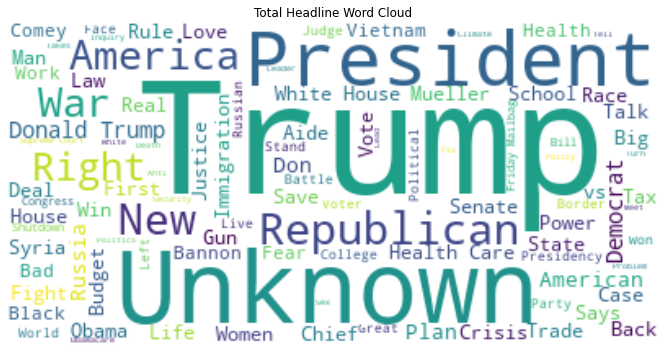

In [ ]:
# Get stopwords from wordcloud library
stopwords = set(STOPWORDS)

# Add some extra words ad hoc for our purpose
app_words = ['br', 'will', 'seem', 'want',"going","us","still","time","one","thank","article","know",
             "even",'thing',"something","say","now",'without','another','anyone','let','go','day',
             'well','seems','must','said','much','someone','person','yet','Mr',"every","put","find",
             'always','give','year','take','really','call','thing','sure','people','made','anything',
             'thought','got','see','way','think','least','less','good','two','look','need','many','make',
             'come','may','might','things','done','happen','part','actually','comment','become','nothing',
             'already','maybe','year','end','next','today','needs','never','blow','course','wants','instead',
             'everyone','guy','little','perhaps']
stopwords.update(app_words) 
# join all reviews
text = " ".join(title for title in dfart_kept.headline)
 
# Generate the image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(text)
 
# visualize the image
fig=plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Total Headline Word Cloud')
plt.show()

Now we try to diffenrenciate the articles gathering mostly positive feelings from the mostly negative ones.

In [ ]:
art_score = dict()
for ID in Article : 
  article = comandlabel_wv.loc[comandlabel_wv.articleID == ID]
  score = sum(1*(article.LabelPredictionRF == 0))/len(article)
  art_score[ID] = score

In [ ]:
# We keep positive articles
art_to_keep = []
for id in art_score.keys():
  if art_score[id]>=0.5:
    art_to_keep.append(id)

index_to_keep = []
for i in range(len(dfart_kept)):
  if dfart_kept.articleID[i] in art_to_keep:
    index_to_keep.append(i)
  
dfart_pos = dfart_kept.iloc[index_to_keep].reset_index(drop=True)
del art_to_keep
dfart_pos.head()

,articleID,headline,keywords
0,586a0d8795d0e039260789b6,America Becomes a Stan,"['Trump, Donald J', 'United States Politics an..."
1,586afcfe95d0e03926078aee,Health Reform Could Outlast Repeal Efforts,"['Health Insurance and Managed Care', 'Patient..."
2,586b0a7495d0e03926078b03,House G.O.P. Votes to Gut an Office Reviewing ...,"['House of Representatives', 'House Committee ..."
3,586b10be95d0e03926078b11,Lessons From the Tea Party,"['Tea Party Movement', 'Democratic Party', 'Ho..."
4,586b5ef495d0e03926078b68,The Snapchat Presidency,"['Trump, Donald J', 'United States Politics an..."


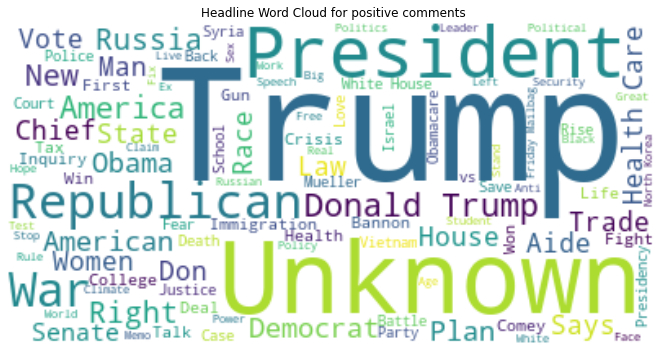

In [ ]:
text_pos = " ".join(title for title in dfart_pos.headline)
 
# Generate the image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(text_pos)
 
# visualize the image
fig=plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Headline Word Cloud for positive comments')
plt.show()

In [ ]:
# source : https://stackabuse.com/python-how-to-flatten-list-of-lists/ 
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


def remove_stopwords(text):
  text_list = tokenize_url_hashtags(text)
  new_text = []
  pun = string.punctuation + '’‘'
  table = str.maketrans('', '', pun)
  stripped = [w.translate(table) for w in flatten_list(text_list)]
  for word in stripped:
    if len(word)>1:
      if word.lower() not in stopwords :
        new_text.append(word)
  return new_text

titlepos = Counter(remove_stopwords(dfart_pos.headline))
titlepos.most_common(10)

100%|██████████| 2049/2049 [00:00<00:00, 11437.98it/s]


[('trump', 416),
 ('unknown', 100),
 ('presid', 75),
 ('mr', 44),
 ('health', 42),
 ('donald', 41),
 ('republican', 40),
 ('new', 38),
 ('hous', 37),
 ('war', 37)]

In [ ]:
keywords_pos = []
for i in range(len(dfart_pos)):
  for word in dfart_pos.keywords[i].split('\''):
    if len(word)>2 : 
      keywords_pos.append(word.lower())

keywords_pos[:10]

['trump, donald j',
 'united states politics and government',
 'ethics and official misconduct',
 'corruption (institutional)',
 'conflicts of interest',
 'appointments and executive changes',
 'democracy (theory and philosophy)',
 'comey, james b',
 'health insurance and managed care',
 'patient protection and affordable care act (2010)']

In [ ]:
Pos = Counter(keywords_pos)
Pos.most_common(10)

[('trump, donald j', 1135),
 ('united states politics and government', 1032),
 ('republican party', 266),
 ('united states international relations', 190),
 ('house of representatives', 139),
 ('presidential election of 2016', 124),
 ('russia', 122),
 ('senate', 116),
 ('democratic party', 115),
 ('russian interference in 2016 us elections and ties to trump associates',
  111)]

This list of keywords is not without reminding us of the Democrat cluster created in the first experiment.

In [ ]:
# We only keep negative articles
art_to_keep = []
for id in art_score.keys():
  if art_score[id]<0.5:
    art_to_keep.append(id)

index_to_keep = []
for i in range(len(dfart_kept)):
  if dfart_kept.articleID[i] in art_to_keep:
    index_to_keep.append(i)

dfart_neg = dfart_kept.iloc[index_to_keep].reset_index(drop=True)
del index_to_keep, art_to_keep
dfart_neg.head()

,articleID,headline,keywords
0,58691a5795d0e039260788b9,G.O.P. Leadership Poised to Topple Obama’s Pi...,"['United States Politics and Government', 'Law..."
1,586a0d8795d0e039260789b3,Sprint and Mr. Trump’s Fictional Jobs,"['Trump, Donald J', 'Son, Masayoshi', 'Wireles..."
2,586b037e95d0e03926078af5,"Mr. Trump, Bureaucracy Apprentice","['Government Employees', 'United States Politi..."
3,58705c7995d0e0392607972d,Arms and the Trump,"['Gun Control', 'Murders, Attempted Murders an..."
4,5870f3c195d0e039260797a9,A Second Empire by Trump’s Side,"['Conflicts of Interest', 'Kushner, Jared', 'W..."


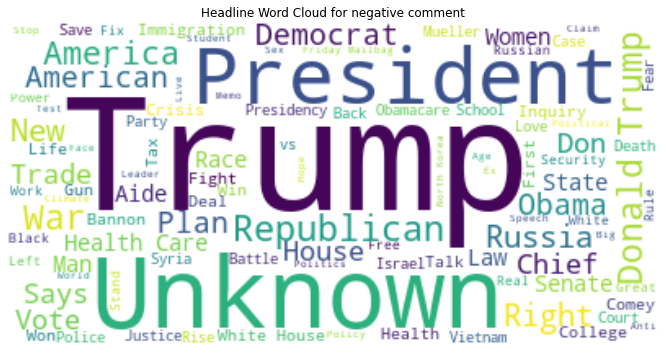

In [ ]:
text = " ".join(title for title in dfart_pos.headline)
 
# Generate the image
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=100).generate(text)
 
# visualize the image
fig=plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Headline Word Cloud for negative comment')
plt.show()

In [ ]:
keywords_neg = []
for i in range(len(dfart_neg)):
  for word in dfart_neg.keywords[i].split('\''):
    if len(word)>2 : 
      keywords_neg.append(word.lower())

keywords_neg[:10]

['united states politics and government',
 'law and legislation',
 'house of representatives',
 'senate',
 'patient protection and affordable care act (2010)',
 'trump, donald j',
 'mcconnell, mitch',
 'trump, donald j',
 'son, masayoshi',
 'wireless communications']

In [ ]:
Neg = Counter(keywords_neg)
Neg.most_common(10)

[('trump, donald j', 420),
 ('united states politics and government', 386),
 ('republican party', 105),
 ('senate', 65),
 ('house of representatives', 62),
 ('democratic party', 60),
 ('immigration and emigration', 57),
 ('russian interference in 2016 us elections and ties to trump associates',
  49),
 ('united states international relations', 48),
 ('presidential election of 2016', 46)]

We find this time a bit more of Republica preoccupation associated with negative feelings.